In [2]:
pip install prophet

     |████████████████████████████████| 8.8 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 3.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [834]:
%matplotlib inline
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import prophet

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [801]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Predicted[1:] - Actual[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

# data prep

In [9]:
east = pd.read_csv('data/east_daily.csv', index_col=0, parse_dates=[0])
midwest = pd.read_csv('data/midwest_daily.csv', index_col=0, parse_dates=[0]) 
south = pd.read_csv('data/south_daily.csv', index_col=0, parse_dates=[0]) 
west = pd.read_csv('data/west_daily.csv', index_col=0, parse_dates=[0]) 

In [12]:
east = east.sort_index()
midwest = midwest.sort_index()
south = south.sort_index()
west = west.sort_index()

In [313]:
train_size = int(len(east) * 0.9)

east_train, east_test = east[0:train_size], east[train_size:]
print(east_train.shape, east_test.shape)

midwest_train, midwest_test = midwest[0:train_size], midwest[train_size:]
print(midwest_train.shape, midwest_test.shape)

south_train, south_test = south[0:train_size], south[train_size:]
print(south_train.shape, south_test.shape)

west_train, west_test = west[0:train_size], west[train_size:]
print(west_train.shape, west_test.shape)

(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)


In [202]:
east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(south_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(west_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
date,,
2020-02-12,NaN,0.0
2020-02-13,NaN,0.0
2020-02-14,NaN,0.0
2020-02-15,NaN,0.0
2020-02-16,NaN,0.0
...,...,...
2023-03-19,0.0,NaN
2023-03-20,37.0,NaN
2023-03-21,33.0,NaN


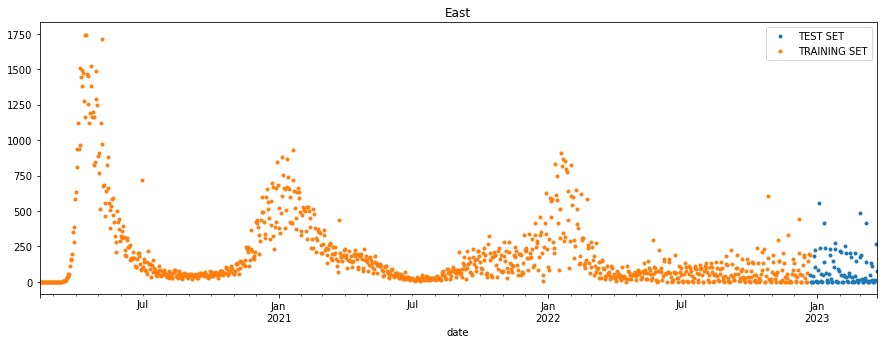

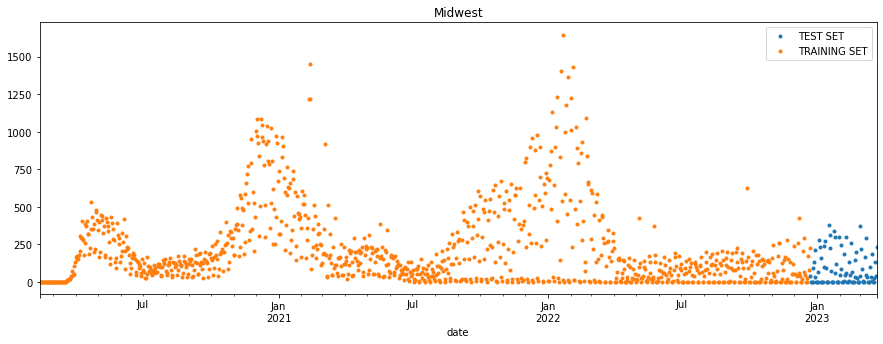

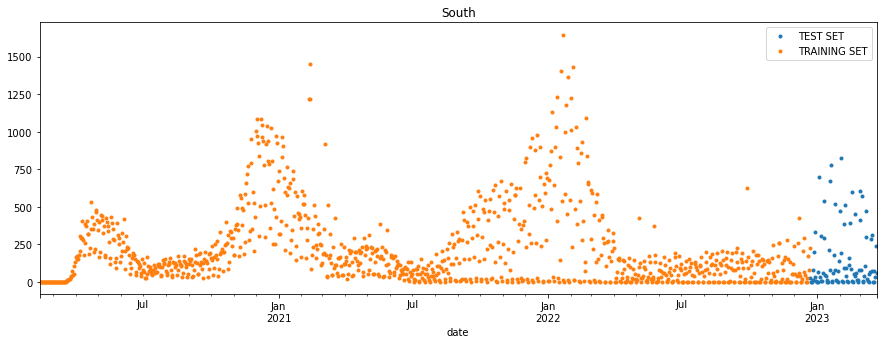

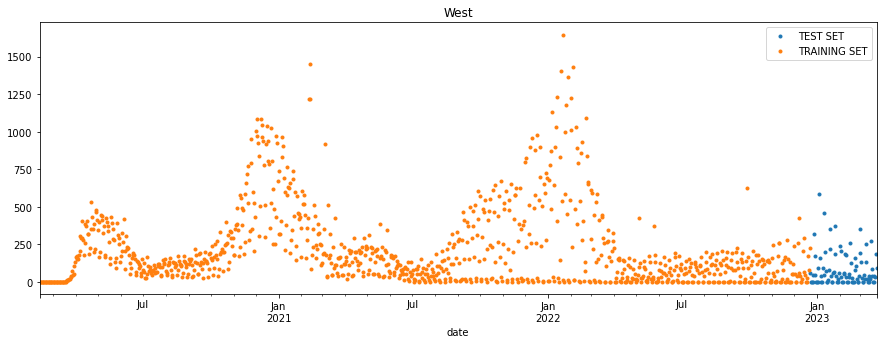

In [203]:
_ = east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Midwest', style='.')

_ = south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='South', style='.')

_ = west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='West', style='.')

# Univariate Prophet

### east

In [314]:
east_model = prophet.Prophet().fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))



03:05:56 - cmdstanpy - INFO - Chain [1] start processing
03:05:56 - cmdstanpy - INFO - Chain [1] done processing


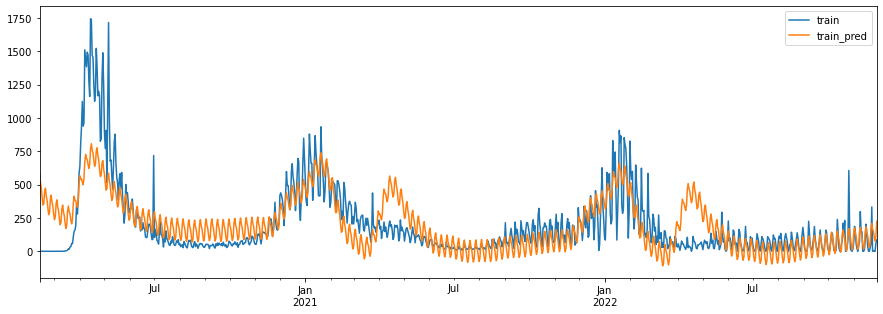

Training Set Metrics:
MAE: 126.31169182411163
MASE: 0.0005386064020969436


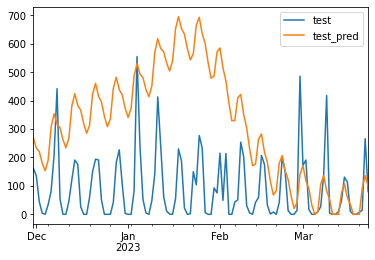

Testing Set Metrics:
MAE: 242.5279650823465
MASE: 0.008174503612576286


In [315]:
train_pred=east_model.predict(east_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([east_train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(east_train.values, train_pred['yhat'].values)
mase_train = MASE(east_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=east_model.predict(east_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
east_test[east_test<0] = 0
pd.concat([east_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(east_test.values, test_pred['yhat'].values)
mase_test = MASE(east_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

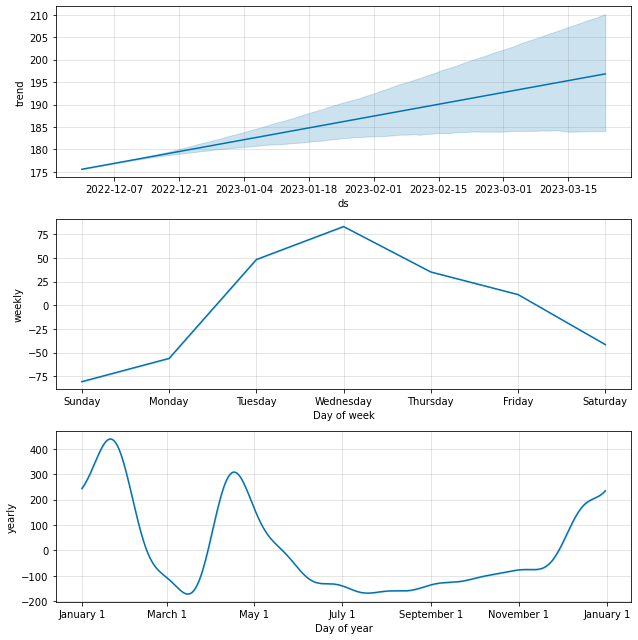

In [316]:
test_pred = test_pred.reset_index()

fig = east_model.plot_components(test_pred)
plt.show()

In [422]:
east_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

east_model2.add_seasonality(name='weekly', period=7, fourier_order=1) # decrease weekly (default is 3)
east_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1, prior_scale = 0.01) 

east_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

03:28:12 - cmdstanpy - INFO - Chain [1] start processing
03:28:12 - cmdstanpy - INFO - Chain [1] done processing


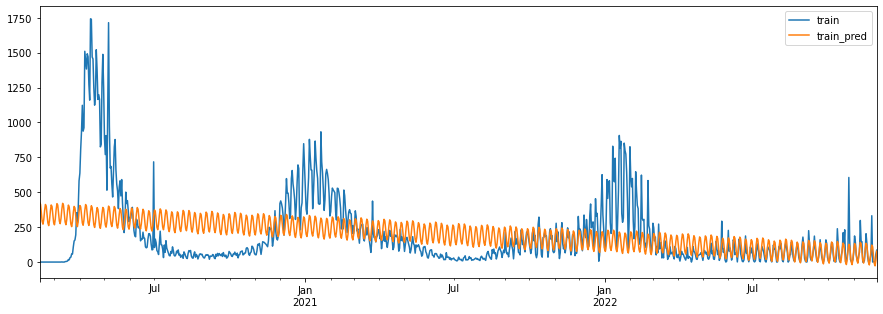

Training Set Metrics:
MAE: 158.86615366461862
MASE: 0.0007987154721858529


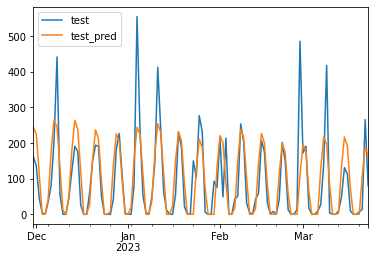

Testing Set Metrics:
MAE: 45.44767698379004
MASE: 0.0036194239688761456


In [421]:
train_pred=east_model2.predict(east_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([east_train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(east_train.values, train_pred['yhat'].values)
mase_train = MASE(east_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=east_model2.predict(east_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
east_test[east_test<0] = 0
pd.concat([east_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(east_test.values, test_pred['yhat'].values)
mase_test = MASE(east_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

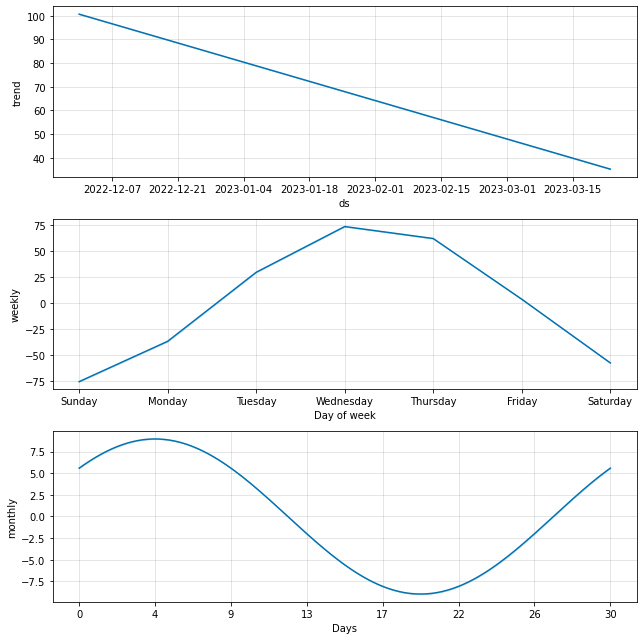

In [319]:
test_pred = test_pred.reset_index()

fig = east_model2.plot_components(test_pred)
plt.show()

### midwest

In [120]:
midwest_model = prophet.Prophet().fit(midwest_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing


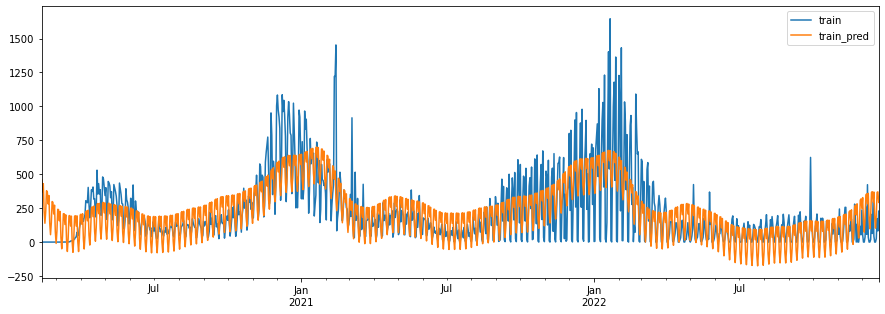

Training Set Metrics:
MAE: 123.46899038751779
MASE: 0.0005039781034335188


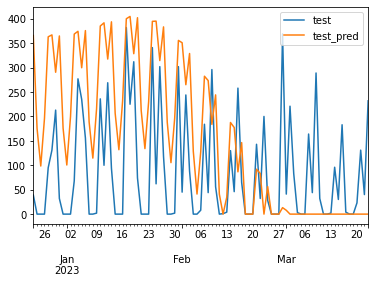

Testing Set Metrics:
MAE: 124.93075155778845
MASE: 0.009188716178868244


In [121]:
train_pred=midwest_model.predict(midwest_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([midwest_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(midwest_train.values, train_pred['yhat'].values)
mase_train = MASE(midwest_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=midwest_model.predict(midwest_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(midwest_test.values, test_pred['yhat'].values)
mase_test = MASE(midwest_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

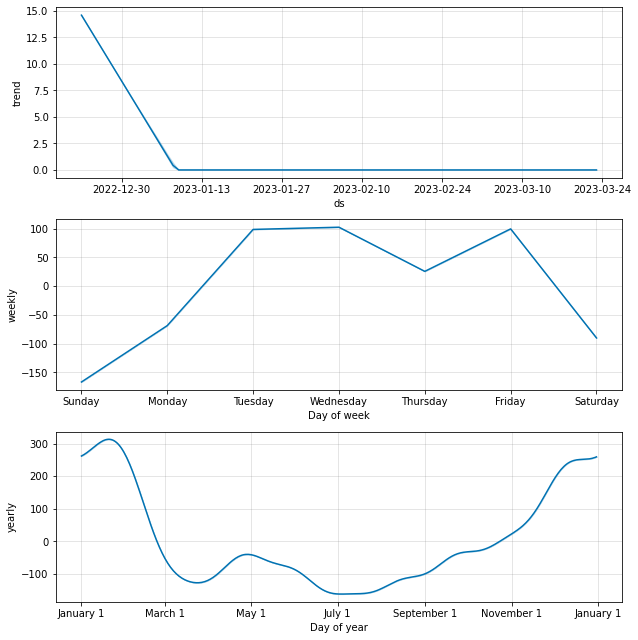

In [122]:
test_pred = test_pred.reset_index()

fig = midwest_model.plot_components(test_pred)
plt.show()

In [418]:
midwest_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

midwest_model2.add_seasonality(name='weekly', period=7, fourier_order=1) # add weekly (default is 3)
midwest_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1, prior_scale = 0.01) 

midwest_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

03:27:39 - cmdstanpy - INFO - Chain [1] start processing
03:27:39 - cmdstanpy - INFO - Chain [1] done processing


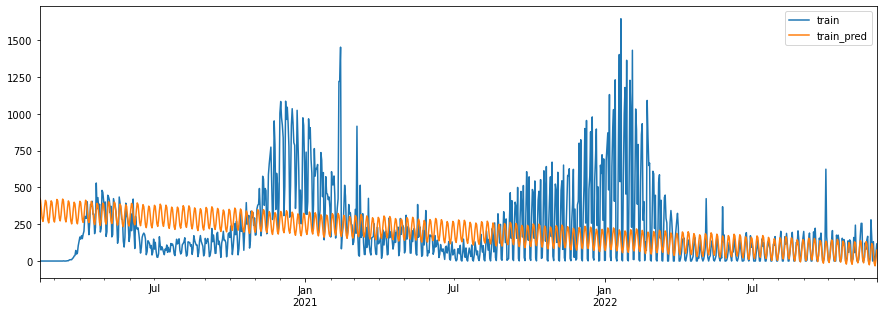

Training Set Metrics:
MAE: 164.73294139440995
MASE: 0.000813770476267849


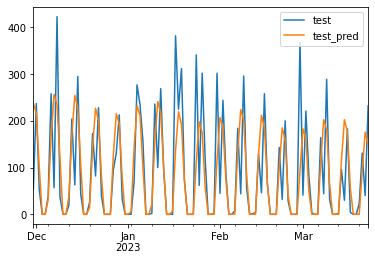

Testing Set Metrics:
MAE: 50.472215964858194
MASE: 0.004138515629691905


In [419]:
train_pred=midwest_model2.predict(midwest_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([midwest_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(midwest_train.values, train_pred['yhat'].values)
mase_train = MASE(midwest_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=midwest_model2.predict(midwest_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(midwest_test.values, test_pred['yhat'].values)
mase_test = MASE(midwest_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### south

In [423]:
south_model = prophet.Prophet().fit(south_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


03:28:18 - cmdstanpy - INFO - Chain [1] start processing
03:28:19 - cmdstanpy - INFO - Chain [1] done processing


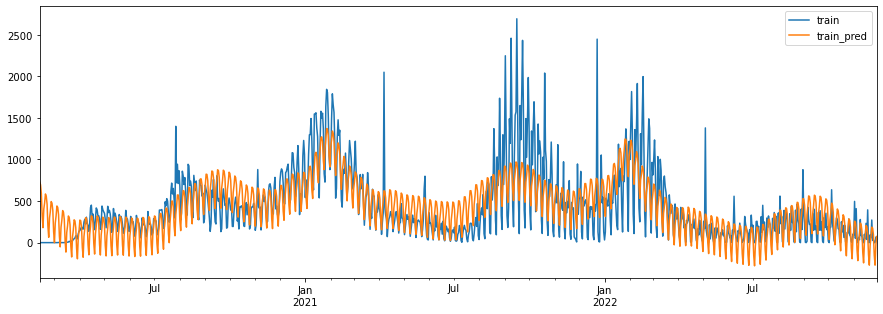

Training Set Metrics:
MAE: 208.75841189868515
MASE: 0.0005076086356317453


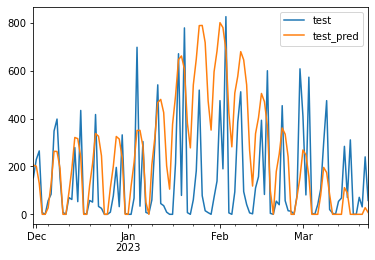

Testing Set Metrics:
MAE: 181.15935254019678
MASE: 0.006491558502120127


In [424]:
train_pred=south_model.predict(south_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([south_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(south_train.values, train_pred['yhat'].values)
mase_train = MASE(south_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=south_model.predict(south_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
south_test[south_test<0] = 0
pd.concat([south_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(south_test.values, test_pred['yhat'].values)
mase_test = MASE(south_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

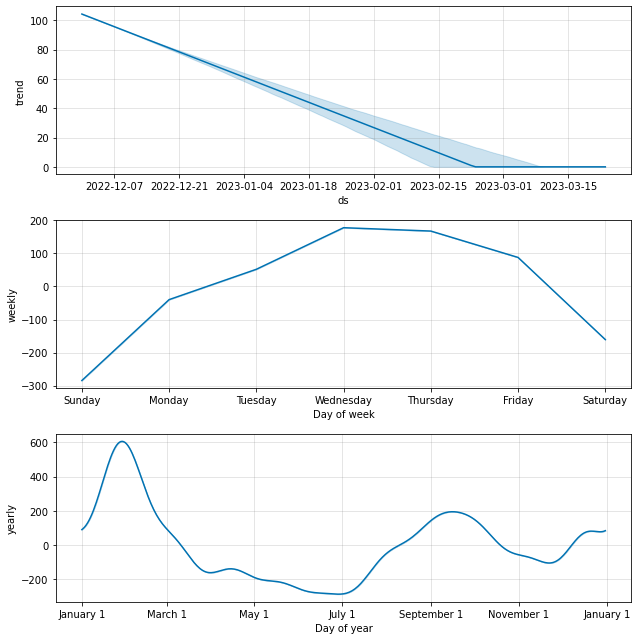

In [425]:
test_pred = test_pred.reset_index()

fig = south_model.plot_components(test_pred)
plt.show()

In [426]:
south_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

south_model2.add_seasonality(name='weekly', period=7, fourier_order=8, prior_scale = 20) # add weekly (default is 3)
south_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1, prior_scale = 0.01) 

south_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

03:28:22 - cmdstanpy - INFO - Chain [1] start processing
03:28:22 - cmdstanpy - INFO - Chain [1] done processing


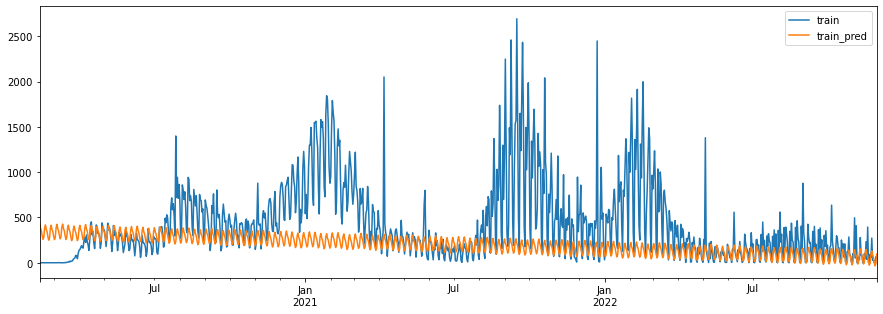

Training Set Metrics:
MAE: 290.32470730337747
MASE: 0.0008735356387037365


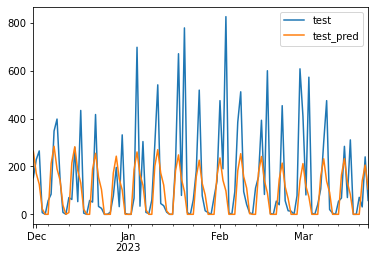

Testing Set Metrics:
MAE: 101.70273626643025
MASE: 0.00562502567761799


In [427]:
train_pred=south_model2.predict(south_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([south_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(south_train.values, train_pred['yhat'].values)
mase_train = MASE(south_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=south_model2.predict(south_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
south_test[south_test<0] = 0
pd.concat([south_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(south_test.values, test_pred['yhat'].values)
mase_test = MASE(south_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### west

In [428]:
west_model = prophet.Prophet().fit(west_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


03:29:12 - cmdstanpy - INFO - Chain [1] start processing
03:29:12 - cmdstanpy - INFO - Chain [1] done processing


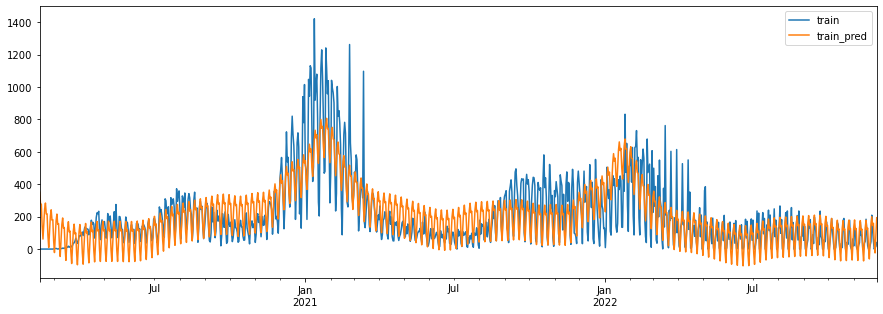

Training Set Metrics:
MAE: 95.048850991629
MASE: 0.0004682512001673937


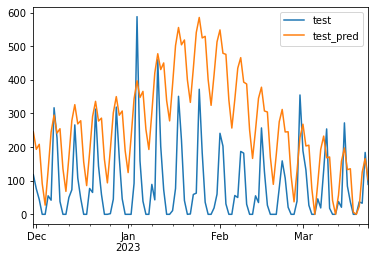

Testing Set Metrics:
MAE: 189.11045001820386
MASE: 0.007810493804211584


In [429]:
train_pred=west_model.predict(west_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([west_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(west_train.values, train_pred['yhat'].values)
mase_train = MASE(west_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=west_model.predict(west_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
west_test[west_test<0] = 0
pd.concat([west_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(west_test.values, test_pred['yhat'].values)
mase_test = MASE(west_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

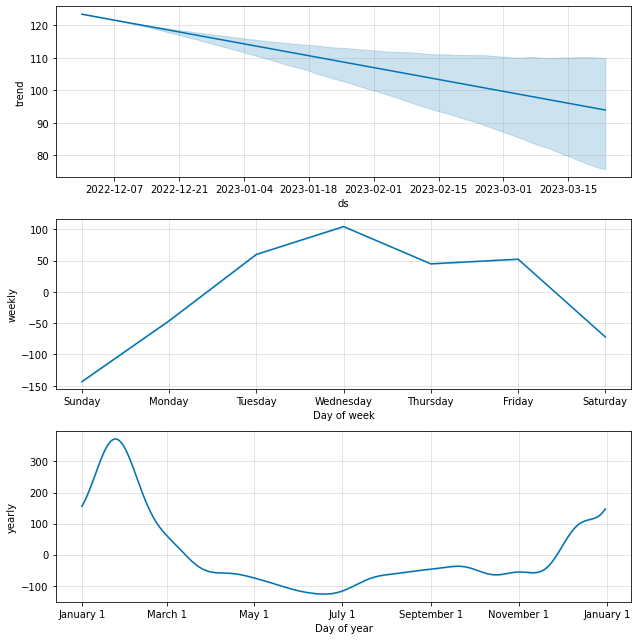

In [430]:
test_pred = test_pred.reset_index()

fig = west_model.plot_components(test_pred)
plt.show()

In [431]:
west_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

west_model2.add_seasonality(name='weekly', period=7, fourier_order=8, prior_scale = 20) # add weekly (default is 3)
west_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1, prior_scale = 0.01) 
west_model2.add_seasonality(name='yearly', period=365, fourier_order=1, prior_scale = 0.001) 

west_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

03:29:14 - cmdstanpy - INFO - Chain [1] start processing
03:29:14 - cmdstanpy - INFO - Chain [1] done processing


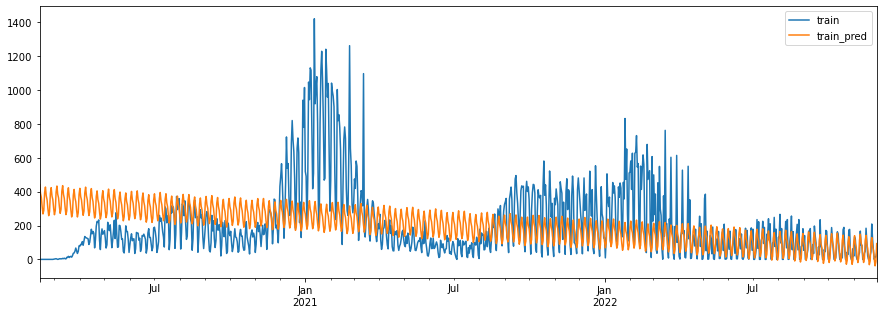

Training Set Metrics:
MAE: 148.00749813314334
MASE: 0.0008358238913086887


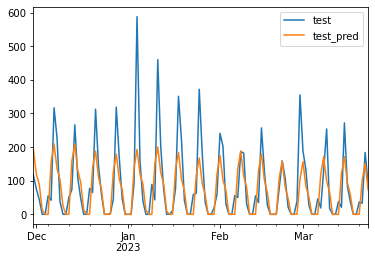

Testing Set Metrics:
MAE: 49.1394991030547
MASE: 0.0045657613929406355


In [432]:
train_pred=west_model2.predict(west_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([west_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(west_train.values, train_pred['yhat'].values)
mase_train = MASE(west_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=west_model2.predict(west_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
west_test[west_test<0] = 0
pd.concat([west_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(west_test.values, test_pred['yhat'].values)
mase_test = MASE(west_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

# Multivariate Prophet

In [438]:
all_features = pd.read_csv('data/multivar_data/finaldataall.csv')
selected_features = pd.read_csv('data/multivar_data/finaldata_selectedfeatures.csv')

In [455]:
all_features = all_features.drop(['region_Puerto_Rico'], axis=1)

In [456]:
for col in all_features.columns:
    print(col)

date
location
year
mmwr_week
covid_19_deaths
distributed
distributed_janssen
distributed_moderna
distributed_pfizer
distributed_novavax
distributed_unk_manuf
dist_per_100k
distributed_per_100k_5plus
distributed_per_100k_12plus
distributed_per_100k_18plus
distributed_per_100k_65plus
administered
administered_5plus
administered_12plus
administered_18plus
administered_65plus
administered_janssen
administered_moderna
administered_pfizer
administered_novavax
administered_unk_manuf
admin_per_100k
admin_per_100k_5plus
admin_per_100k_12plus
admin_per_100k_18plus
admin_per_100k_65plus
recip_administered
administered_dose1_recip
administered_dose1_pop_pct
administered_dose1_recip_5plus
administered_dose1_recip_5plus_pop_pct
administered_dose1_recip_12plus
administered_dose1_recip_12plus_pop_pct
administered_dose1_recip_18plus
administered_dose1_recip_18plus_pop_pct
administered_dose1_recip_65plus
administered_dose1_recip_65plus_pop_pct
series_complete_yes
series_complete_pop_pct
series_complete_

In [443]:
all_features.head()

,date,location,year,mmwr_week,covid_19_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_novavax,...,quarter,dayofyear,dayofmonth,weekofyear,holidays_Holiday,holidays_Normal_day,month_sin,month_cos,dayofweek_sin,dayofweek_cos
0,2020-01-04,AL,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
1,2020-01-04,LA,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
2,2020-01-04,VA,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
3,2020-01-04,KY,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521
4,2020-01-04,KS,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.5,0.866025,-0.974928,-0.222521


In [444]:
all_features.tail()

,date,location,year,mmwr_week,covid_19_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_novavax,...,quarter,dayofyear,dayofmonth,weekofyear,holidays_Holiday,holidays_Normal_day,month_sin,month_cos,dayofweek_sin,dayofweek_cos
7301,2023-02-25,CO,2023,8,22.0,17340235.0,501900.0,6060640.0,10749595.0,28100.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7302,2023-02-25,MI,2023,8,69.0,28917130.0,967600.0,11182320.0,16740610.0,26600.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7303,2023-02-25,MD,2023,8,45.0,21829280.0,616400.0,7305760.0,13876420.0,30700.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7304,2023-02-25,LA,2023,8,24.0,10141420.0,330300.0,4094680.0,5707940.0,8500.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521
7305,2023-02-25,NM,2023,8,10.0,6047345.0,190600.0,2338600.0,3511145.0,7000.0,...,1,56,25,8,0,1,0.866025,0.5,-0.974928,-0.222521


In [463]:
all_features.loc[all_features['region_East'] == 1]

,date,location,year,mmwr_week,covid_19_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_novavax,...,quarter,dayofyear,dayofmonth,weekofyear,holidays_Holiday,holidays_Normal_day,month_sin,month_cos,dayofweek_sin,dayofweek_cos
11,2020-01-04,ME,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.500000,0.866025,-0.974928,-0.222521
17,2020-01-04,CT,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.500000,0.866025,-0.974928,-0.222521
25,2020-01-04,MA,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.500000,0.866025,-0.974928,-0.222521
26,2020-01-04,PA,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.500000,0.866025,-0.974928,-0.222521
34,2020-01-04,NY,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,4,1,0,1,0.500000,0.866025,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7277,2023-02-25,CT,2023,8,22.0,11677565.0,355100.0,4514680.0,6799185.0,8600.0,...,1,56,25,8,0,1,0.866025,0.500000,-0.974928,-0.222521
7283,2023-02-25,PA,2023,8,110.0,41739215.0,1569200.0,15502820.0,24610095.0,57100.0,...,1,56,25,8,0,1,0.866025,0.500000,-0.974928,-0.222521
7284,2023-02-25,MA,2023,8,59.0,23152420.0,633400.0,8775580.0,13731440.0,12000.0,...,1,56,25,8,0,1,0.866025,0.500000,-0.974928,-0.222521
7292,2023-02-25,ME,2023,8,10.0,4845030.0,159400.0,1817620.0,2861610.0,6400.0,...,1,56,25,8,0,1,0.866025,0.500000,-0.974928,-0.222521


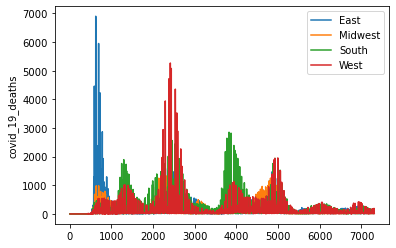

In [476]:
# blue line - East
sns.lineplot(x =  all_features.loc[all_features['region_East'] == 1].index, y = all_features.loc[all_features['region_East'] == 1]['covid_19_deaths'])

# orange line - Midwest
sns.lineplot(x =  all_features.loc[all_features['region_Midwest'] == 1].index, y = all_features.loc[all_features['region_Midwest'] == 1]['covid_19_deaths'])

# green line - South
sns.lineplot(x =  all_features.loc[all_features['region_South'] == 1].index, y = all_features.loc[all_features['region_South'] == 1]['covid_19_deaths'])

# red line - West
sns.lineplot(x =  all_features.loc[all_features['region_West'] == 1].index, y = all_features.loc[all_features['region_West'] == 1]['covid_19_deaths'])

plt.legend(labels = ['East', 'Midwest', 'South', 'West'])


# Data Processing

In [506]:
multi_prophet = all_features

multi_prophet = multi_prophet.rename(columns={'date': 'ds', 'covid_19_deaths': 'y'})

multi_prophet = multi_prophet.drop(['year','month','deaths_1_year_lag','deaths_1_andhalf_year_lag', 'deaths_2_years_lag',
       'deaths_half_year_lag_mean', 'deaths_1_year_lag_mean',
       'deaths_1_andhalf_year_lag_mean', 'deaths_2_years_lag_mean',
       'deaths_half_year_lag_std', 'deaths_1_year_lag_std',
       'deaths_1_andhalf_year_lag_std', 'deaths_2_years_lag_std','deaths_half_year_lag_max', 'deaths_1_year_lag_max',
       'deaths_1_andhalf_year_lag_max', 'deaths_2_years_lag_max',
       'deaths_half_year_lag_min', 'deaths_1_year_lag_min',
       'deaths_1_andhalf_year_lag_min', 'deaths_2_years_lag_min', 'date.1',
       'dayofweek', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear', 'holidays_Holiday',
       'holidays_Normal_day', 'month_sin', 'month_cos', 'dayofweek_sin',
       'dayofweek_cos', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter',
       'deaths_half_year_lag', 'mmwr_week'], axis=1)

In [508]:
for col in multi_prophet.columns:
    print(col)

ds
location
y
distributed
distributed_janssen
distributed_moderna
distributed_pfizer
distributed_novavax
distributed_unk_manuf
dist_per_100k
distributed_per_100k_5plus
distributed_per_100k_12plus
distributed_per_100k_18plus
distributed_per_100k_65plus
administered
administered_5plus
administered_12plus
administered_18plus
administered_65plus
administered_janssen
administered_moderna
administered_pfizer
administered_novavax
administered_unk_manuf
admin_per_100k
admin_per_100k_5plus
admin_per_100k_12plus
admin_per_100k_18plus
admin_per_100k_65plus
recip_administered
administered_dose1_recip
administered_dose1_pop_pct
administered_dose1_recip_5plus
administered_dose1_recip_5plus_pop_pct
administered_dose1_recip_12plus
administered_dose1_recip_12plus_pop_pct
administered_dose1_recip_18plus
administered_dose1_recip_18plus_pop_pct
administered_dose1_recip_65plus
administered_dose1_recip_65plus_pop_pct
series_complete_yes
series_complete_pop_pct
series_complete_5plus
series_complete_5plus_pop

In [511]:
start_date = '2020-01-04'
end_date = '2023-02-25'
train_end_date = '2022-12-31'

In [512]:
# Train test split
train = multi_prophet[multi_prophet['ds'] <= train_end_date]
test = multi_prophet[multi_prophet['ds'] > train_end_date]

# Check the shape of the dataset
print(train.shape)
print(test.shape)

(6974, 106)
(332, 106)


In [514]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['ds'].min())
print('The end time of the training dataset is ', train['ds'].max())
print('The start time of the testing dataset is ', test['ds'].min())
print('The end time of the testing dataset is ', test['ds'].max())

The start time of the training dataset is  2020-01-04
The end time of the training dataset is  2022-12-31
The start time of the testing dataset is  2023-01-07
The end time of the testing dataset is  2023-02-25


# Baseline Model

In [838]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = prophet.Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

11:34:11 - cmdstanpy - INFO - Chain [1] start processing
11:34:13 - cmdstanpy - INFO - Chain [1] done processing


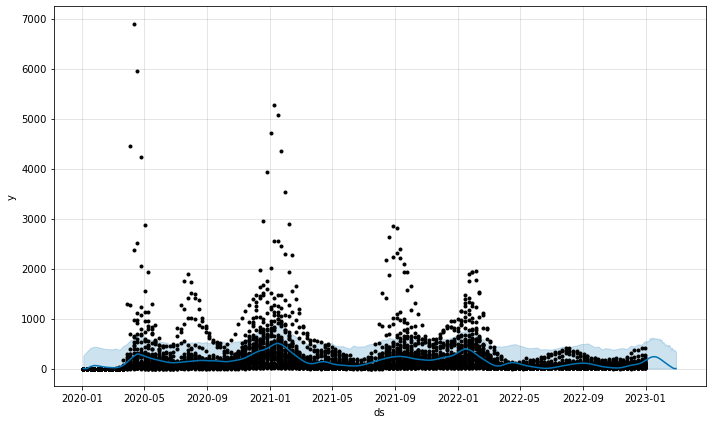

In [839]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=60)

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_baseline[col] = forecast_baseline[col].clip(lower=0.0)

# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

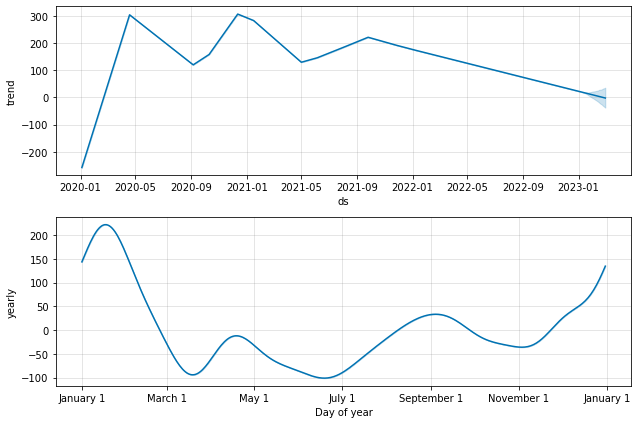

In [840]:
model_baseline.plot_components(forecast_baseline);

In [841]:
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MASE value
performance_baseline_MAPE = MASE(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MASE for the baseline model is {performance_baseline_MAPE}')

performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 104.26800037549035
The MASE for the baseline model is 1.0015731071798215
The MAPE for the baseline model is 2009594223556457.2


## Tuning Changepoints

In [842]:
print(f'There are {len(model_baseline.changepoints)} change points. \nThe change points dates are \n{train.loc[train["ds"].isin(model_baseline.changepoints)]}')

There are 25 change points. 
The change points dates are 
Empty DataFrame
Columns: [ds, location, y, distributed, distributed_janssen, distributed_moderna, distributed_pfizer, distributed_novavax, distributed_unk_manuf, dist_per_100k, distributed_per_100k_5plus, distributed_per_100k_12plus, distributed_per_100k_18plus, distributed_per_100k_65plus, administered, administered_5plus, administered_12plus, administered_18plus, administered_65plus, administered_janssen, administered_moderna, administered_pfizer, administered_novavax, administered_unk_manuf, admin_per_100k, admin_per_100k_5plus, admin_per_100k_12plus, admin_per_100k_18plus, admin_per_100k_65plus, recip_administered, administered_dose1_recip, administered_dose1_pop_pct, administered_dose1_recip_5plus, administered_dose1_recip_5plus_pop_pct, administered_dose1_recip_12plus, administered_dose1_recip_12plus_pop_pct, administered_dose1_recip_18plus, administered_dose1_recip_18plus_pop_pct, administered_dose1_recip_65plus, administ

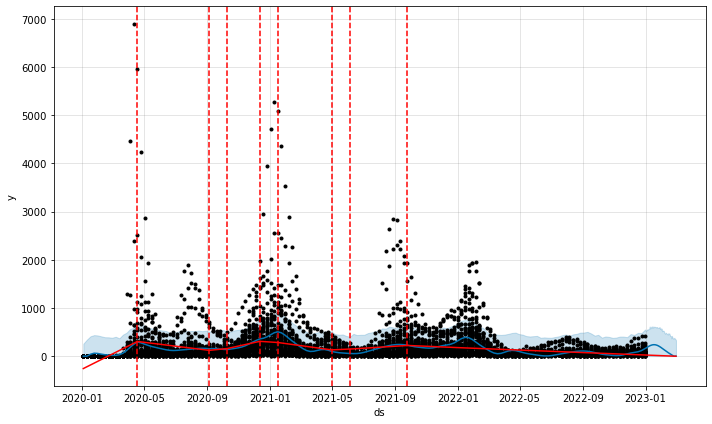

In [843]:
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

In [862]:
# Create the prophet model with confidence internal of 95%
model_changepoint = prophet.Prophet(interval_width=0.95, n_changepoints=3)
# Fit the model using the training dataset
model_changepoint.fit(train)


11:40:14 - cmdstanpy - INFO - Chain [1] start processing
11:40:15 - cmdstanpy - INFO - Chain [1] done processing


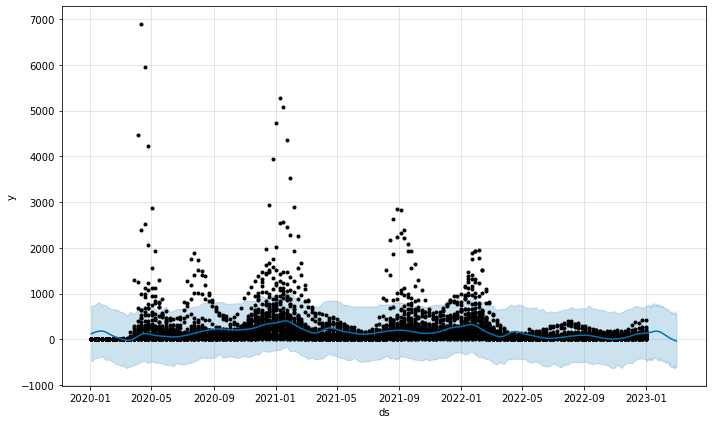

In [863]:
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=60)

# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)

# Visualize the forecast
model_changepoint.plot(forecast_changepoint); # Add semi-colon to remove the duplicated chart

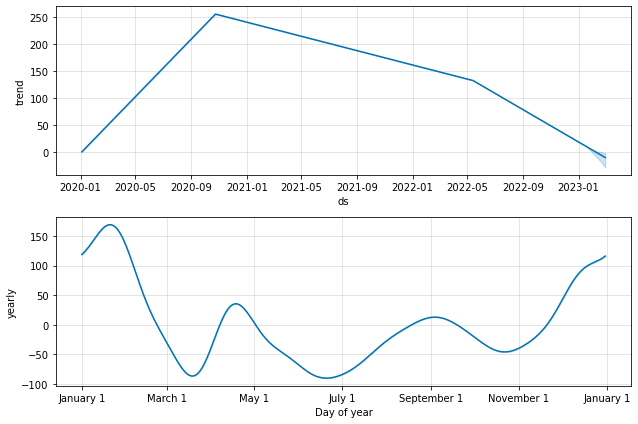

In [864]:
# Visualize the forecast components
model_changepoint.plot_components(forecast_changepoint);

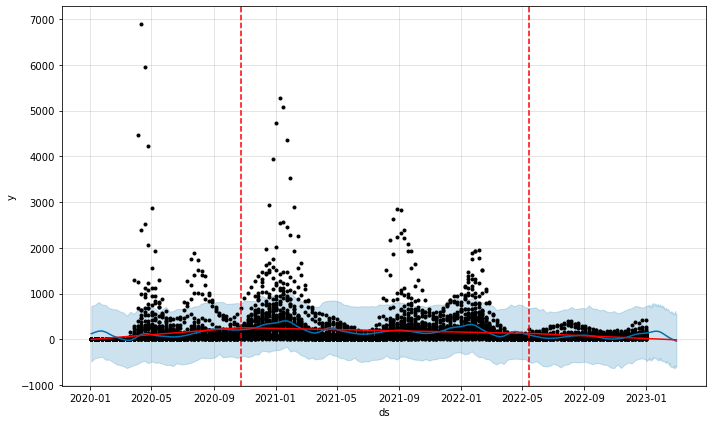

In [865]:
# Change points to plot
fig = model_changepoint.plot(forecast_changepoint)
a = add_changepoints_to_plot(fig.gca(), model_changepoint, forecast_changepoint)

In [866]:
# Merge actual and predicted values
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAE for the baseline model is {performance_changepoint_MAE}')

# Check MAPE value
performance_changepoint_MASE = MASE(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAPE for the baseline model is {performance_changepoint_MASE}')

The MAE for the baseline model is 80.52324135247203
The MAPE for the baseline model is 1.0016655976572333


## Add Seasonality

In [867]:
# Add seasonality
model_season = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, n_changepoints = 3)

# Fit the model on the training dataset
model_season.fit(train)

11:47:54 - cmdstanpy - INFO - Chain [1] start processing
11:47:54 - cmdstanpy - INFO - Chain [1] done processing


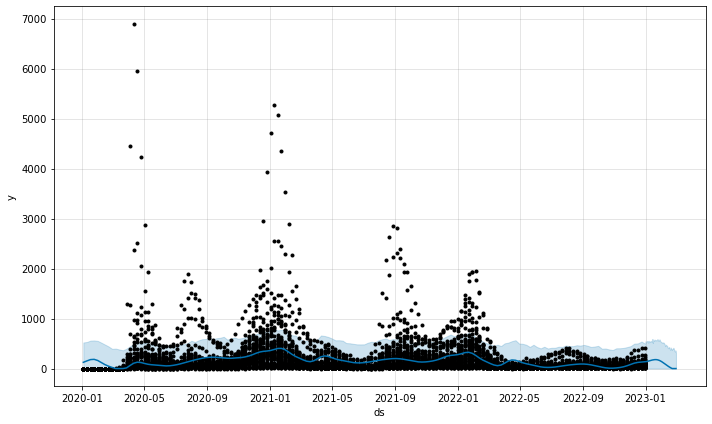

In [868]:
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=60)

# Make prediction
forecast_season = model_season.predict(future_season)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_season[col] = forecast_season[col].clip(lower=0.0)

# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

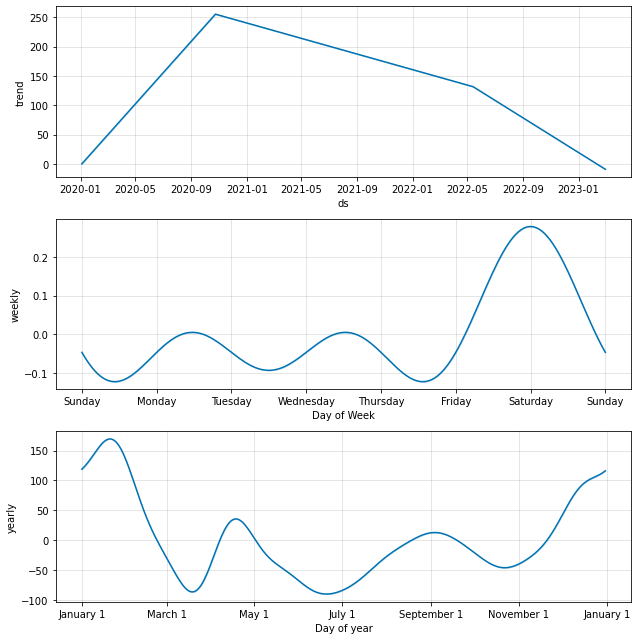

In [869]:
model_season.plot_components(forecast_season);

In [870]:
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MASE value
performance_baseline_MASE = MASE(performance_season['y'], performance_season['yhat'])
print(f'The MASE for the baseline model is {performance_baseline_MASE}')

The MAE for the seasonality model is 78.80186441638617
The MASE for the baseline model is 1.0010821488339643


### no yearly seasonality

In [874]:
# Add seasonality
model_season = prophet.Prophet(yearly_seasonality=False, weekly_seasonality=True, n_changepoints = 3)

# Fit the model on the training dataset
model_season.fit(train)

# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=60)

# Make prediction
forecast_season = model_season.predict(future_season)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_season[col] = forecast_season[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MASE value
performance_season_MASE = MASE(performance_season['y'], performance_season['yhat'])
print(f'The MASE for the baseline model is {performance_season_MASE}')

11:48:42 - cmdstanpy - INFO - Chain [1] start processing
11:48:42 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the seasonality model is 47.491149157377
The MASE for the baseline model is 0.9985880423977153


### no weekly seasonality

In [873]:
# Add seasonality
model_season = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=False, n_changepoints = 3)

# Fit the model on the training dataset
model_season.fit(train)

# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=60)

# Make prediction
forecast_season = model_season.predict(future_season)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_season[col] = forecast_season[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MASE value
performance_season_MASE = MASE(performance_season['y'], performance_season['yhat'])
print(f'The MASE for the baseline model is {performance_season_MASE}')

11:48:36 - cmdstanpy - INFO - Chain [1] start processing
11:48:36 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the seasonality model is 78.39553562235047
The MASE for the baseline model is 1.0010747225977488


### neither yearly or weekly seasonality

In [876]:
# Add seasonality
model_season = prophet.Prophet(yearly_seasonality=False, weekly_seasonality=False, n_changepoints = 3)

# Fit the model on the training dataset
model_season.fit(train)

# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=60)

# Make prediction
forecast_season = model_season.predict(future_season)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_season[col] = forecast_season[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MASE value
performance_season_MASE = MASE(performance_season['y'], performance_season['yhat'])
print(f'The MASE for the baseline model is {performance_season_MASE}')

11:49:04 - cmdstanpy - INFO - Chain [1] start processing
11:49:04 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the seasonality model is 47.32220396200185
The MASE for the baseline model is 0.9985994191885433


best so far:
- no yearly and no weekly
- no yearly, yes weekly

## adding holiday effect

In [877]:
# Add holidays
model_holiday = prophet.Prophet(n_changepoints=3)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')


# Fit the model on the training dataset
model_holiday.fit(train)

# All the holidays and events
model_holiday.train_holiday_names

11:50:26 - cmdstanpy - INFO - Chain [1] start processing
11:50:27 - cmdstanpy - INFO - Chain [1] done processing
11:50:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:50:27 - cmdstanpy - INFO - Chain [1] start processing
11:50:32 - cmdstanpy - INFO - Chain [1] done processing


0                                      New Year's Day
1                                        Memorial Day
2                                    Independence Day
3                         Independence Day (observed)
4                                           Labor Day
5                                        Veterans Day
6                                        Thanksgiving
7                                       Christmas Day
8                          Martin Luther King Jr. Day
9                               Washington's Birthday
10                                       Columbus Day
11                          New Year's Day (observed)
12               Juneteenth National Independence Day
13    Juneteenth National Independence Day (observed)
14                           Christmas Day (observed)
dtype: object

The MAE for the seasonality model is 75.7850951406589
The MASE for the baseline model is 1.0013285086273354


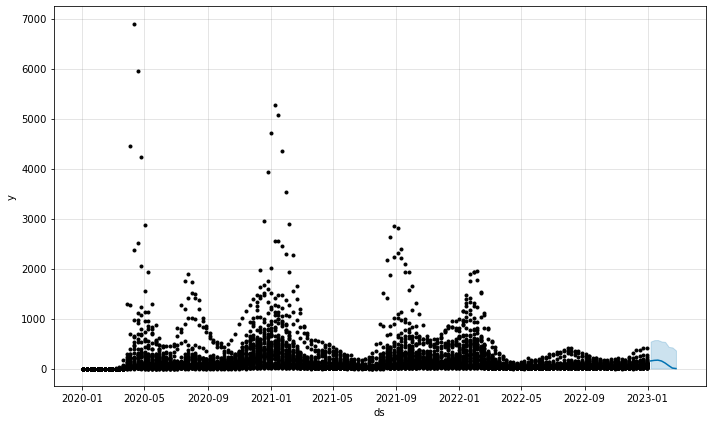

In [879]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=60)

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_holiday[col] = forecast_holiday[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the seasonality model is {performance_holiday_MAE}')

# Check MASE value
performance_holiday_MASE = MASE(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MASE for the baseline model is {performance_holiday_MASE}')

# Visualize the forecast
model_holiday.plot(performance_holiday); # Add semi-colon to remove the duplicated chart

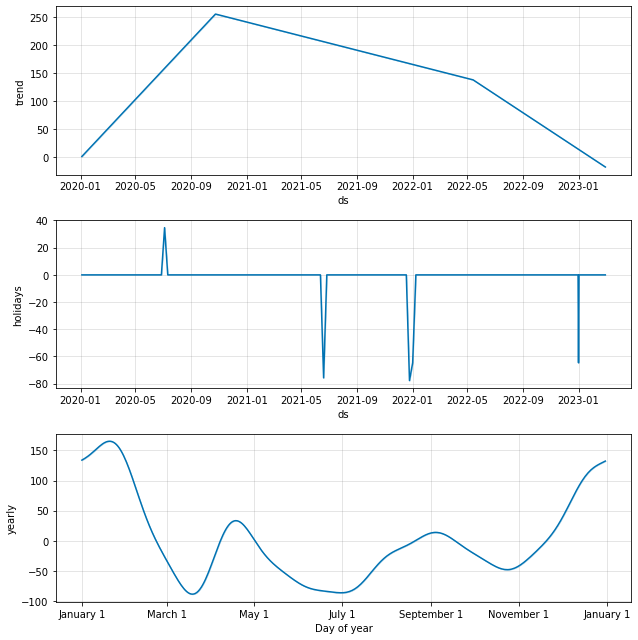

In [880]:
model_holiday.plot_components(forecast_holiday);

## Seasonality and Holidays

In [881]:
model_season = prophet.Prophet(yearly_seasonality=False, weekly_seasonality=True, n_changepoints = 3)
model_season.add_country_holidays(country_name='US')

In [882]:
# Fit the model on the training dataset
model_season.fit(train)

# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=60)

# Make prediction
forecast_season = model_season.predict(future_season)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_season[col] = forecast_season[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MASE value
performance_season_MASE = MASE(performance_season['y'], performance_season['yhat'])
print(f'The MASE for the baseline model is {performance_season_MASE}')

11:56:52 - cmdstanpy - INFO - Chain [1] start processing
11:56:52 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the seasonality model is 46.23622967246496
The MASE for the baseline model is 0.9987057595917129


# Multivariate Model

In [951]:
feature_list = ['distributed',
 'distributed_janssen',
 'distributed_moderna',
 'distributed_pfizer',
 'distributed_novavax',
 'distributed_unk_manuf',
 'dist_per_100k',
 'distributed_per_100k_5plus',
 'distributed_per_100k_12plus',
 'distributed_per_100k_18plus',
 'distributed_per_100k_65plus',
 'administered',
 'administered_5plus',
 'administered_12plus',
 'administered_18plus',
 'administered_65plus',
 'administered_janssen',
 'administered_moderna',
 'administered_pfizer',
 'administered_novavax',
 'administered_unk_manuf',
 'admin_per_100k',
 'admin_per_100k_5plus',
 'admin_per_100k_12plus',
 'admin_per_100k_18plus',
 'admin_per_100k_65plus',
 'recip_administered',
 'administered_dose1_recip',
 'administered_dose1_pop_pct',
 'administered_dose1_recip_5plus',
 'administered_dose1_recip_5plus_pop_pct',
 'administered_dose1_recip_12plus',
 'administered_dose1_recip_12plus_pop_pct',
 'administered_dose1_recip_18plus',
 'administered_dose1_recip_18plus_pop_pct',
 'administered_dose1_recip_65plus',
 'administered_dose1_recip_65plus_pop_pct',
 'series_complete_yes',
 'series_complete_pop_pct',
 'series_complete_5plus',
 'series_complete_5plus_pop_pct',
 'series_complete_12plus',
 'series_complete_12plus_pop_pct',
 'series_complete_18plus',
 'series_complete_18plus_pop_pct',
 'series_complete_65plus',
 'series_complete_65plus_pop_pct',
 'series_complete_janssen',
 'series_complete_moderna',
 'series_complete_pfizer',
 'series_complete_novavax',
 'series_complete_unk_manuf',
 'series_complete_janssen_5plus',
 'series_complete_moderna_5plus',
 'series_complete_pfizer_5plus',
 'series_complete_unk_manuf_5plus',
 'series_complete_janssen_12plus',
 'series_complete_moderna_12plus',
 'series_complete_pfizer_12plus',
 'series_complete_unk_manuf_12plus',
 'series_complete_janssen_18plus',
 'series_complete_moderna_18plus',
 'series_complete_pfizer_18plus',
 'series_complete_unk_manuf_18plus',
 'series_complete_janssen_65plus',
 'series_complete_moderna_65plus',
 'series_complete_pfizer_65plus',
 'series_complete_unk_manuf_65plus',
 'additional_doses',
 'additional_doses_vax_pct',
 'additional_doses_5plus',
 'additional_doses_12plus',
 'additional_doses_12plus_vax_pct',
 'additional_doses_18plus',
 'additional_doses_18plus_vax_pct',
 'additional_doses_50plus',
 'additional_doses_50plus_vax_pct',
 'additional_doses_65plus',
 'additional_doses_65plus_vax_pct',
 'additional_doses_moderna',
 'additional_doses_pfizer',
 'additional_doses_janssen',
 'additional_doses_unk_manuf',
 'second_booster',
 'second_booster_50plus',
 'second_booster_65plus',
 'second_booster_janssen',
 'second_booster_moderna',
 'second_booster_pfizer',
 'second_booster_unk_manuf',
 'administered_bivalent',
 'admin_bivalent_pfr',
 'admin_bivalent_mod',
 'dist_bivalent_pfr',
 'dist_bivalent_mod',
 'bivalent_booster_5plus',
 'bivalent_booster_12plus',
 'bivalent_booster_18plus',
 'bivalent_booster_65plus',
 'region_East',
 'region_Midwest',
 'region_South',
 'region_West']

In [943]:
train_imputed = train.fillna(0)

In [1023]:
# Add seasonality, holidays, and changepoints
model_multivariate = prophet.Prophet(yearly_seasonality = False, weekly_seasonality = True, n_changepoints = 3)
model_multivariate.add_country_holidays(country_name='US')

# Add regressor
for feature in feature_list:
    model_multivariate.add_regressor(feature)

# Fit the model on the training dataset
model_multivariate.fit(train_imputed)

14:59:57 - cmdstanpy - INFO - Chain [1] start processing
15:00:17 - cmdstanpy - INFO - Chain [1] done processing


In [987]:
feature_list_copy = feature_list.copy()
feature_list_copy.append('ds')

In [1024]:
test_imputed = test.fillna(0)

In [1026]:
all_features = all_features.rename(columns={'date': 'ds'})
all_features['ds']= pd.to_datetime(all_features['ds'])
all_features_imputed = all_features.fillna(0)

multi_prophet['ds']= pd.to_datetime(multi_prophet['ds'])
multi_prophet = multi_prophet.fillna(0)

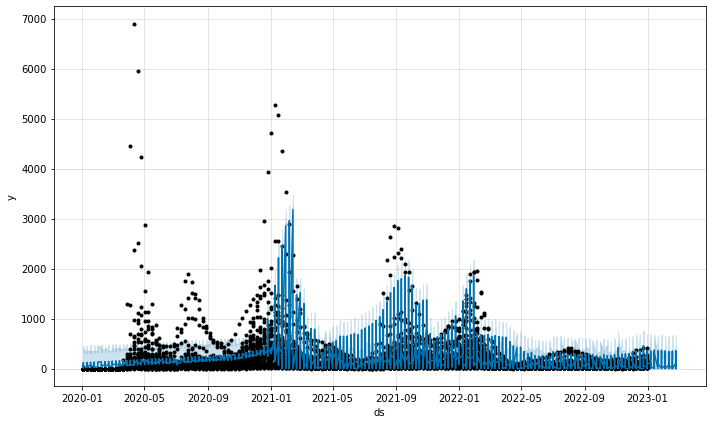

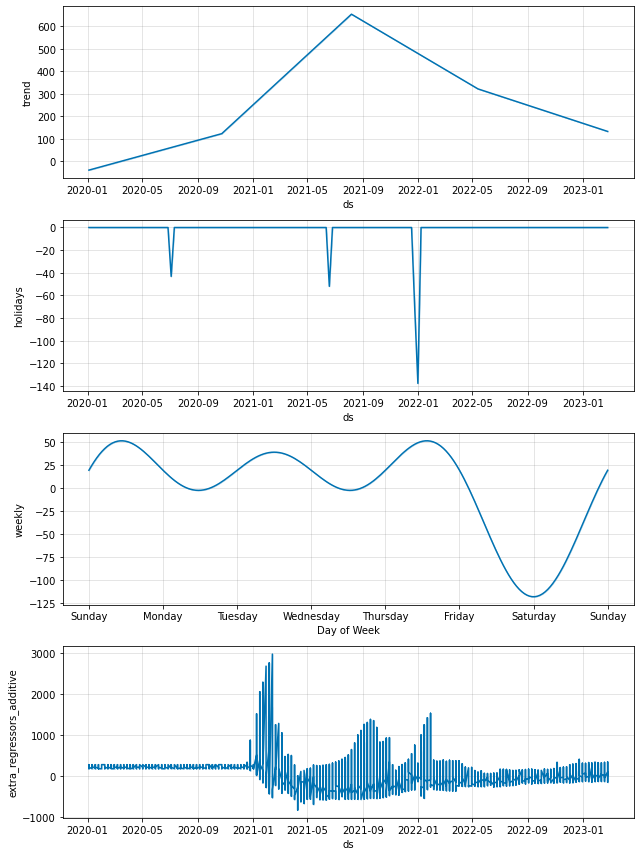

In [993]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods = 60)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, multi_prophet[feature_list_copy], on='ds', how='inner')

# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_multivariate[col] = forecast_multivariate[col].clip(lower=0.0)
    
# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [994]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MASE value
performance_multivariate_MASE = MASE(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MASE}')

The MAE for the multivariate model is 61.76084625943221
The MAPE for the multivariate model is 1.0005103578648882


In [1028]:
test_pred = model_multivariate.predict(test_imputed)

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 85.37418983726498
Testing MASE: 0.9986885677794477


### without seasonality

In [1029]:
# Add seasonality
model_multivariate = prophet.Prophet(n_changepoints = 3)

# Add regressor
for feature in feature_list:
    model_multivariate.add_regressor(feature)

# Fit the model on the training dataset
model_multivariate.fit(train_imputed)

15:00:43 - cmdstanpy - INFO - Chain [1] start processing
15:01:07 - cmdstanpy - INFO - Chain [1] done processing


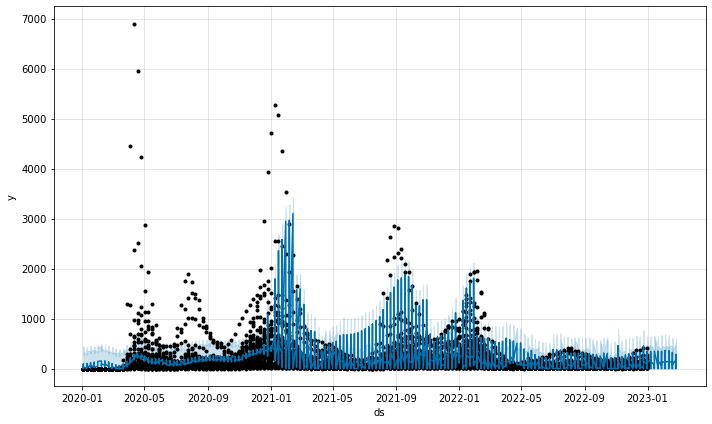

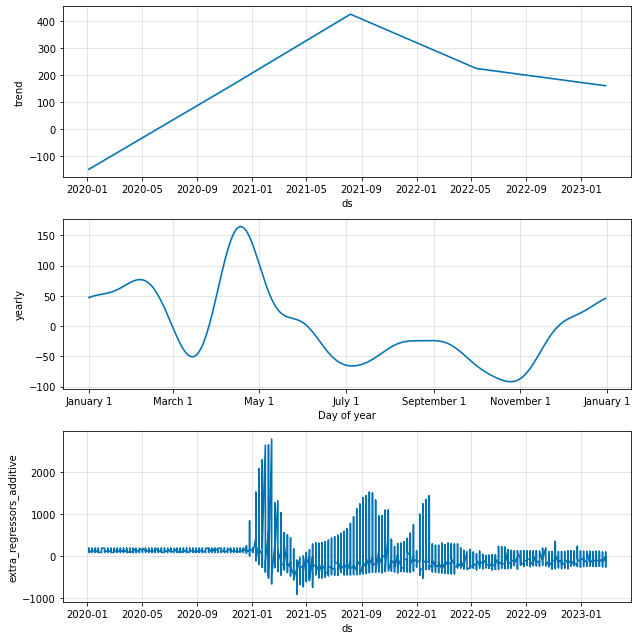

In [962]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods = 60)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, all_features_imputed[feature_list_copy], on='ds', how='inner')

# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_multivariate[col] = forecast_multivariate[col].clip(lower=0.0)
    
# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [963]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MASE value
performance_multivariate_MASE = MASE(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MASE for the multivariate model is {performance_multivariate_MASE}')

The MAE for the multivariate model is 82.44729169258599
The MAPE for the multivariate model is 1.0005989286021528


In [1031]:
test_pred = model_multivariate.predict(test_imputed)

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 97.96131515828489
Testing MASE: 1.000737546292253


### without change points

In [1032]:
# Add seasonality
model_multivariate = prophet.Prophet(yearly_seasonality = False, weekly_seasonality = True)
model_multivariate.add_country_holidays(country_name='US')

# Add regressor
for feature in feature_list:
    model_multivariate.add_regressor(feature)

# Fit the model on the training dataset
model_multivariate.fit(train_imputed)

15:01:26 - cmdstanpy - INFO - Chain [1] start processing
15:01:56 - cmdstanpy - INFO - Chain [1] done processing


In [974]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods = 60)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, all_features_imputed[feature_list_copy], on='ds', how='inner')

# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_multivariate[col] = forecast_multivariate[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MASE value
performance_multivariate_MASE = MASE(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MASE for the multivariate model is {performance_multivariate_MASE}')

The MAE for the multivariate model is 66.18585072892988
The MASE for the multivariate model is 1.0006490101587273


In [1033]:
test_pred = model_multivariate.predict(test_imputed)

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 82.86067668158026
Testing MASE: 0.999431306797041


### using regressors with the highest correlation

In [1000]:
# Set the correlation threshold
correlation_threshold = 0.05

# Create a correlation matrix
correlation_matrix = multi_prophet.corr()

# Extract the correlations with the target variable above the threshold
correlations_above_threshold = correlation_matrix['y'][correlation_matrix['y'].abs() > correlation_threshold]

# Sort the correlations in descending order
correlated_list = list(correlations_above_threshold.index)

In [1001]:
correlated_list.remove('y')

In [1018]:
# Add seasonality, holidays, and changepoints
model_multivariate = prophet.Prophet(yearly_seasonality = False, weekly_seasonality = True, n_changepoints = 3)
model_multivariate.add_country_holidays(country_name='US')

# Add regressor
for feature in correlated_list:
    model_multivariate.add_regressor(feature)

# Fit the model on the training dataset
model_multivariate.fit(train_imputed)

14:57:16 - cmdstanpy - INFO - Chain [1] start processing
14:57:33 - cmdstanpy - INFO - Chain [1] done processing


In [1019]:
test_pred = model_multivariate.predict(test)

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 83.00595693124107
Testing MASE: 0.9983855900746964


In [1034]:
# Add seasonality, holidays, and changepoints
model_multivariate = prophet.Prophet(yearly_seasonality = False, weekly_seasonality = True)
model_multivariate.add_country_holidays(country_name='US')

# Add regressor
for feature in correlated_list:
    model_multivariate.add_regressor(feature)

# Fit the model on the training dataset
model_multivariate.fit(train_imputed)

15:03:05 - cmdstanpy - INFO - Chain [1] start processing
15:03:41 - cmdstanpy - INFO - Chain [1] done processing


In [1035]:
test_pred = model_multivariate.predict(test_imputed)

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 77.77514442958385
Testing MASE: 0.9972239649058169


# Log

In [1042]:
train['log_deaths'] = np.log(train['y'])
test['log_deaths'] = np.log(test['y'])

# Cross Validation

In [1057]:
train.shape

(6974, 107)

In [1059]:
from prophet.diagnostics import cross_validation

data_cv = cross_validation(model_holiday, initial='720 days', period='20 days', horizon = '30 days', parallel="processes")
data_cv.head()

15:23:26 - cmdstanpy - INFO - Chain [1] start processing
15:23:26 - cmdstanpy - INFO - Chain [1] start processing
15:23:26 - cmdstanpy - INFO - Chain [1] start processing
15:23:26 - cmdstanpy - INFO - Chain [1] start processing
15:23:27 - cmdstanpy - INFO - Chain [1] done processing
15:23:27 - cmdstanpy - INFO - Chain [1] done processing
15:23:27 - cmdstanpy - INFO - Chain [1] done processing
15:23:27 - cmdstanpy - INFO - Chain [1] done processing
15:23:29 - cmdstanpy - INFO - Chain [1] start processing
15:23:29 - cmdstanpy - INFO - Chain [1] start processing
15:23:30 - cmdstanpy - INFO - Chain [1] start processing
15:23:30 - cmdstanpy - INFO - Chain [1] start processing
15:23:30 - cmdstanpy - INFO - Chain [1] done processing
15:23:31 - cmdstanpy - INFO - Chain [1] done processing
15:23:31 - cmdstanpy - INFO - Chain [1] done processing
15:23:31 - cmdstanpy - INFO - Chain [1] done processing
15:23:35 - cmdstanpy - INFO - Chain [1] start processing
15:23:35 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-01,379.855643,-67.656430,826.515317,629.0,2021-12-26
1,2022-01-01,379.855643,-62.662711,836.845655,63.0,2021-12-26
2,2022-01-01,379.855643,-94.800907,820.952027,304.0,2021-12-26
3,2022-01-01,379.855643,-61.829091,838.365509,38.0,2021-12-26
4,2022-01-01,379.855643,-57.818959,818.339908,54.0,2021-12-26


In [1060]:
from prophet.diagnostics import performance_metrics

# Model performance metrics
data_p = performance_metrics(data_cv)
data_p.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days,37206.561976,192.890026,103.245018,0.881274,1.048456,0.973344
1,4 days,19199.798791,138.563339,81.245128,0.823275,0.980523,0.985857
2,5 days,9099.300981,95.390256,59.926640,0.664259,0.842306,0.993967
3,6 days,16261.957247,127.522379,84.073321,0.948538,1.036195,0.994012
4,7 days,53112.082007,230.460587,133.446741,1.010448,1.331428,0.964072


In [1061]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  

# Use cross validation to evaluate all parameters
for params in all_params:
    m = prophet.Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='720 days', period='20 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print(tuning_results)

15:25:55 - cmdstanpy - INFO - Chain [1] start processing
15:25:55 - cmdstanpy - INFO - Chain [1] done processing
15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:17 - cmdstanpy - INFO - Chain [1] start processing
15:26:19 - cmdstanpy - INFO - Chain [1] done processing
15:26:19 - cmdstanpy - INFO - Chain [1] done processing
15:26:21 - cmdstanpy - INFO - Chain [1] done processing
15:26:22 - cmdstanpy - INFO - Chain [1] done processing
15:26:24 - cmdstanpy - INFO - Chain [1] start processing
15:26:24 - cmdstanpy - INFO - Chain [1] start processing
15:26:25 - cmdstanpy - INFO - Chain [1] done processing
15:26:25 - cmdstanpy - INFO - Chain [1] start processing
15:26:26 - cmdstanpy - INFO - Chain [1] done processing
15:26:26 - cmdstanpy - INFO - Chain [1] start processing
15:26:27 - cmdstanpy - INFO - Chain [1] done processing
15:26:28 - cmdstanpy - INFO - Chain [1]

15:28:48 - cmdstanpy - INFO - Chain [1] done processing
15:28:49 - cmdstanpy - INFO - Chain [1] done processing
15:28:49 - cmdstanpy - INFO - Chain [1] done processing
15:28:50 - cmdstanpy - INFO - Chain [1] start processing
15:28:50 - cmdstanpy - INFO - Chain [1] start processing
15:28:51 - cmdstanpy - INFO - Chain [1] done processing
15:28:51 - cmdstanpy - INFO - Chain [1] done processing
15:28:53 - cmdstanpy - INFO - Chain [1] start processing
15:28:54 - cmdstanpy - INFO - Chain [1] done processing
15:29:05 - cmdstanpy - INFO - Chain [1] start processing
15:29:05 - cmdstanpy - INFO - Chain [1] start processing
15:29:05 - cmdstanpy - INFO - Chain [1] start processing
15:29:05 - cmdstanpy - INFO - Chain [1] start processing
15:29:06 - cmdstanpy - INFO - Chain [1] done processing
15:29:06 - cmdstanpy - INFO - Chain [1] done processing
15:29:06 - cmdstanpy - INFO - Chain [1] done processing
15:29:07 - cmdstanpy - INFO - Chain [1] done processing
15:29:08 - cmdstanpy - INFO - Chain [1] s

15:30:45 - cmdstanpy - INFO - Chain [1] done processing
15:30:46 - cmdstanpy - INFO - Chain [1] start processing
15:30:47 - cmdstanpy - INFO - Chain [1] start processing
15:30:47 - cmdstanpy - INFO - Chain [1] start processing
15:30:47 - cmdstanpy - INFO - Chain [1] start processing
15:30:47 - cmdstanpy - INFO - Chain [1] done processing
15:30:48 - cmdstanpy - INFO - Chain [1] done processing
15:30:49 - cmdstanpy - INFO - Chain [1] done processing
15:30:49 - cmdstanpy - INFO - Chain [1] done processing
15:30:50 - cmdstanpy - INFO - Chain [1] start processing
15:30:50 - cmdstanpy - INFO - Chain [1] start processing
15:30:51 - cmdstanpy - INFO - Chain [1] done processing
15:30:52 - cmdstanpy - INFO - Chain [1] done processing
15:30:53 - cmdstanpy - INFO - Chain [1] start processing
15:30:55 - cmdstanpy - INFO - Chain [1] done processing
15:31:05 - cmdstanpy - INFO - Chain [1] start processing
15:31:05 - cmdstanpy - INFO - Chain [1] start processing
15:31:05 - cmdstanpy - INFO - Chain [1]

15:32:29 - cmdstanpy - INFO - Chain [1] start processing
15:32:29 - cmdstanpy - INFO - Chain [1] start processing
15:32:30 - cmdstanpy - INFO - Chain [1] done processing
15:32:30 - cmdstanpy - INFO - Chain [1] start processing
15:32:30 - cmdstanpy - INFO - Chain [1] done processing
15:32:32 - cmdstanpy - INFO - Chain [1] done processing
15:32:32 - cmdstanpy - INFO - Chain [1] done processing
15:32:32 - cmdstanpy - INFO - Chain [1] start processing
15:32:33 - cmdstanpy - INFO - Chain [1] start processing
15:32:34 - cmdstanpy - INFO - Chain [1] start processing
15:32:34 - cmdstanpy - INFO - Chain [1] done processing
15:32:34 - cmdstanpy - INFO - Chain [1] start processing
15:32:34 - cmdstanpy - INFO - Chain [1] done processing
15:32:35 - cmdstanpy - INFO - Chain [1] done processing
15:32:36 - cmdstanpy - INFO - Chain [1] done processing
15:32:36 - cmdstanpy - INFO - Chain [1] start processing
15:32:36 - cmdstanpy - INFO - Chain [1] start processing
15:32:38 - cmdstanpy - INFO - Chain [1]

15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing
15:34:10 - cmdstanpy - INFO - Chain [1] done processing
15:34:10 - cmdstanpy - INFO - Chain [1] done processing
15:34:11 - cmdstanpy - INFO - Chain [1] start processing
15:34:12 - cmdstanpy - INFO - Chain [1] start processing
15:34:13 - cmdstanpy - INFO - Chain [1] start processing
15:34:14 - cmdstanpy - INFO - Chain [1] start processing
15:34:15 - cmdstanpy - INFO - Chain [1] done processing
15:34:15 - cmdstanpy - INFO - Chain [1] done processing
15:34:16 - cmdstanpy - INFO - Chain [1] done processing
15:34:16 - cmdstanpy - INFO - Chain [1] done processing
15:34:17 - cmdstanpy - INFO - Chain [1] start processing
15:34:17 - cmdstanpy - INFO - Chain [1] start processing
15:34:19 - cmdstanpy - INFO - Chain [1] start processing
15:34:19 - cmdstanpy - INFO - Chain [1] start processing
15:34:19 - cmdstanpy - INFO - Chain [1]

15:35:51 - cmdstanpy - INFO - Chain [1] done processing
15:35:51 - cmdstanpy - INFO - Chain [1] done processing
15:35:51 - cmdstanpy - INFO - Chain [1] done processing
15:35:51 - cmdstanpy - INFO - Chain [1] done processing
15:35:52 - cmdstanpy - INFO - Chain [1] start processing
15:35:53 - cmdstanpy - INFO - Chain [1] start processing
15:35:53 - cmdstanpy - INFO - Chain [1] start processing
15:35:53 - cmdstanpy - INFO - Chain [1] start processing
15:35:53 - cmdstanpy - INFO - Chain [1] done processing
15:35:53 - cmdstanpy - INFO - Chain [1] done processing
15:35:53 - cmdstanpy - INFO - Chain [1] done processing
15:35:54 - cmdstanpy - INFO - Chain [1] done processing
15:35:55 - cmdstanpy - INFO - Chain [1] start processing
15:35:55 - cmdstanpy - INFO - Chain [1] start processing
15:35:55 - cmdstanpy - INFO - Chain [1] start processing
15:35:55 - cmdstanpy - INFO - Chain [1] start processing
15:35:57 - cmdstanpy - INFO - Chain [1] done processing
15:35:57 - cmdstanpy - INFO - Chain [1] 

15:37:30 - cmdstanpy - INFO - Chain [1] start processing
15:37:31 - cmdstanpy - INFO - Chain [1] done processing
15:37:40 - cmdstanpy - INFO - Chain [1] start processing
15:37:40 - cmdstanpy - INFO - Chain [1] start processing
15:37:40 - cmdstanpy - INFO - Chain [1] start processing
15:37:40 - cmdstanpy - INFO - Chain [1] start processing
15:37:40 - cmdstanpy - INFO - Chain [1] done processing
15:37:41 - cmdstanpy - INFO - Chain [1] done processing
15:37:41 - cmdstanpy - INFO - Chain [1] done processing
15:37:41 - cmdstanpy - INFO - Chain [1] done processing
15:37:42 - cmdstanpy - INFO - Chain [1] start processing
15:37:42 - cmdstanpy - INFO - Chain [1] start processing
15:37:42 - cmdstanpy - INFO - Chain [1] start processing
15:37:42 - cmdstanpy - INFO - Chain [1] start processing
15:37:43 - cmdstanpy - INFO - Chain [1] done processing
15:37:43 - cmdstanpy - INFO - Chain [1] done processing
15:37:43 - cmdstanpy - INFO - Chain [1] done processing
15:37:43 - cmdstanpy - INFO - Chain [1]

15:39:06 - cmdstanpy - INFO - Chain [1] done processing
15:39:06 - cmdstanpy - INFO - Chain [1] done processing
15:39:06 - cmdstanpy - INFO - Chain [1] done processing
15:39:07 - cmdstanpy - INFO - Chain [1] start processing
15:39:07 - cmdstanpy - INFO - Chain [1] done processing
15:39:07 - cmdstanpy - INFO - Chain [1] start processing
15:39:08 - cmdstanpy - INFO - Chain [1] done processing
15:39:09 - cmdstanpy - INFO - Chain [1] start processing
15:39:10 - cmdstanpy - INFO - Chain [1] done processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:27 - cmdstanpy - INFO - Chain [1] done processing
15:39:27 - cmdstanpy - INFO - Chain [1] done processing
15:39:27 - cmdstanpy - INFO - Chain [1] done processing
15:39:27 - cmdstanpy - INFO - Chain [1] done processing
15:39:28 - cmdstanpy - INFO - Chain [1] s

15:40:44 - cmdstanpy - INFO - Chain [1] done processing
15:40:44 - cmdstanpy - INFO - Chain [1] start processing
15:40:45 - cmdstanpy - INFO - Chain [1] done processing
15:40:45 - cmdstanpy - INFO - Chain [1] start processing
15:40:45 - cmdstanpy - INFO - Chain [1] start processing
15:40:45 - cmdstanpy - INFO - Chain [1] start processing
15:40:46 - cmdstanpy - INFO - Chain [1] done processing
15:40:46 - cmdstanpy - INFO - Chain [1] done processing
15:40:46 - cmdstanpy - INFO - Chain [1] done processing
15:40:47 - cmdstanpy - INFO - Chain [1] start processing
15:40:48 - cmdstanpy - INFO - Chain [1] start processing
15:40:48 - cmdstanpy - INFO - Chain [1] done processing
15:40:48 - cmdstanpy - INFO - Chain [1] done processing
15:40:50 - cmdstanpy - INFO - Chain [1] start processing
15:40:50 - cmdstanpy - INFO - Chain [1] done processing
15:40:59 - cmdstanpy - INFO - Chain [1] start processing
15:40:59 - cmdstanpy - INFO - Chain [1] start processing
15:40:59 - cmdstanpy - INFO - Chain [1]

15:42:27 - cmdstanpy - INFO - Chain [1] done processing
15:42:27 - cmdstanpy - INFO - Chain [1] start processing
15:42:27 - cmdstanpy - INFO - Chain [1] start processing
15:42:28 - cmdstanpy - INFO - Chain [1] done processing
15:42:28 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:30 - cmdstanpy - INFO - Chain [1] done processing
15:42:30 - cmdstanpy - INFO - Chain [1] start processing
15:42:31 - cmdstanpy - INFO - Chain [1] start processing
15:42:33 - cmdstanpy - INFO - Chain [1] done processing
15:42:33 - cmdstanpy - INFO - Chain [1] start processing
15:42:33 - cmdstanpy - INFO - Chain [1] done processing
15:42:33 - cmdstanpy - INFO - Chain [1] done processing
15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1]

15:44:21 - cmdstanpy - INFO - Chain [1] start processing
15:44:22 - cmdstanpy - INFO - Chain [1] start processing
15:44:22 - cmdstanpy - INFO - Chain [1] done processing
15:44:24 - cmdstanpy - INFO - Chain [1] done processing
15:44:24 - cmdstanpy - INFO - Chain [1] done processing
15:44:24 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] done processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] done processing
15:44:27 - cmdstanpy - INFO - Chain [1] done processing
15:44:27 - cmdstanpy - INFO - Chain [1] done processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:29 - cmdstanpy - INFO - Chain [1] start processing
15:44:29 - cmdstanpy - INFO - Chain [1] done processing
15:44:29 - cmdstanpy - INFO - Chain [1] start processing
15:44:31 - cmdstanpy - INFO - Chain [1]

15:46:12 - cmdstanpy - INFO - Chain [1] done processing
15:46:12 - cmdstanpy - INFO - Chain [1] done processing
15:46:13 - cmdstanpy - INFO - Chain [1] done processing
15:46:13 - cmdstanpy - INFO - Chain [1] done processing
15:46:13 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] done processing
15:46:14 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] done processing
15:46:16 - cmdstanpy - INFO - Chain [1] start processing
15:46:16 - cmdstanpy - INFO - Chain [1] start processing
15:46:16 - cmdstanpy - INFO - Chain [1] done processing
15:46:16 - cmdstanpy - INFO - Chain [1] done processing
15:46:17 - cmdstanpy - INFO - Chain [1] done processing
15:46:18 - cmdstanpy - INFO - Chain [1] done processing
15:46:18 - cmdstanpy - INFO - Chain [1] start processing
15:46:18 - cmdstanpy - INFO - Chain [1] s

15:47:46 - cmdstanpy - INFO - Chain [1] start processing
15:47:46 - cmdstanpy - INFO - Chain [1] done processing
15:47:55 - cmdstanpy - INFO - Chain [1] start processing
15:47:55 - cmdstanpy - INFO - Chain [1] start processing
15:47:55 - cmdstanpy - INFO - Chain [1] start processing
15:47:56 - cmdstanpy - INFO - Chain [1] start processing
15:47:57 - cmdstanpy - INFO - Chain [1] done processing
15:47:57 - cmdstanpy - INFO - Chain [1] done processing
15:47:58 - cmdstanpy - INFO - Chain [1] done processing
15:47:58 - cmdstanpy - INFO - Chain [1] done processing
15:47:58 - cmdstanpy - INFO - Chain [1] start processing
15:47:59 - cmdstanpy - INFO - Chain [1] start processing
15:47:59 - cmdstanpy - INFO - Chain [1] start processing
15:48:00 - cmdstanpy - INFO - Chain [1] done processing
15:48:00 - cmdstanpy - INFO - Chain [1] start processing
15:48:00 - cmdstanpy - INFO - Chain [1] done processing
15:48:01 - cmdstanpy - INFO - Chain [1] start processing
15:48:01 - cmdstanpy - INFO - Chain [1

15:49:27 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing
15:49:29 - cmdstanpy - INFO - Chain [1] done processing
15:49:29 - cmdstanpy - INFO - Chain [1] start processing
15:49:29 - cmdstanpy - INFO - Chain [1] done processing
15:49:30 - cmdstanpy - INFO - Chain [1] done processing
15:49:31 - cmdstanpy - INFO - Chain [1] start processing
15:49:32 - cmdstanpy - INFO - Chain [1] done processing
15:49:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:43 - cmdstanpy - INFO - Chain [1] done processing
15:49:43 - cmdstanpy - INFO - Chain [1] done processing
15:49:44 - cmdstanpy - INFO - Chain [1] done processing
15:49:44 - cmdstanpy - INFO - Chain [1] done processing
15:49:45 - cmdstanpy - INFO - Chain [1] s

15:51:21 - cmdstanpy - INFO - Chain [1] done processing
15:51:22 - cmdstanpy - INFO - Chain [1] done processing
15:51:22 - cmdstanpy - INFO - Chain [1] done processing
15:51:24 - cmdstanpy - INFO - Chain [1] done processing
15:51:24 - cmdstanpy - INFO - Chain [1] start processing
15:51:24 - cmdstanpy - INFO - Chain [1] start processing
15:51:25 - cmdstanpy - INFO - Chain [1] start processing
15:51:26 - cmdstanpy - INFO - Chain [1] done processing
15:51:26 - cmdstanpy - INFO - Chain [1] start processing
15:51:26 - cmdstanpy - INFO - Chain [1] done processing
15:51:27 - cmdstanpy - INFO - Chain [1] done processing
15:51:27 - cmdstanpy - INFO - Chain [1] done processing
15:51:28 - cmdstanpy - INFO - Chain [1] start processing
15:51:29 - cmdstanpy - INFO - Chain [1] done processing
15:51:38 - cmdstanpy - INFO - Chain [1] start processing
15:51:38 - cmdstanpy - INFO - Chain [1] start processing
15:51:38 - cmdstanpy - INFO - Chain [1] start processing
15:51:38 - cmdstanpy - INFO - Chain [1] 

15:53:16 - cmdstanpy - INFO - Chain [1] done processing
15:53:16 - cmdstanpy - INFO - Chain [1] start processing
15:53:17 - cmdstanpy - INFO - Chain [1] done processing
15:53:17 - cmdstanpy - INFO - Chain [1] done processing
15:53:18 - cmdstanpy - INFO - Chain [1] start processing
15:53:18 - cmdstanpy - INFO - Chain [1] done processing
15:53:19 - cmdstanpy - INFO - Chain [1] start processing
15:53:19 - cmdstanpy - INFO - Chain [1] start processing
15:53:20 - cmdstanpy - INFO - Chain [1] done processing
15:53:20 - cmdstanpy - INFO - Chain [1] start processing
15:53:22 - cmdstanpy - INFO - Chain [1] done processing
15:53:22 - cmdstanpy - INFO - Chain [1] done processing
15:53:24 - cmdstanpy - INFO - Chain [1] start processing
15:53:25 - cmdstanpy - INFO - Chain [1] done processing
15:53:25 - cmdstanpy - INFO - Chain [1] start processing
15:53:26 - cmdstanpy - INFO - Chain [1] done processing
15:53:27 - cmdstanpy - INFO - Chain [1] done processing
15:53:28 - cmdstanpy - INFO - Chain [1] s

15:55:30 - cmdstanpy - INFO - Chain [1] done processing
15:55:31 - cmdstanpy - INFO - Chain [1] done processing
15:55:31 - cmdstanpy - INFO - Chain [1] done processing
15:55:32 - cmdstanpy - INFO - Chain [1] done processing
15:55:32 - cmdstanpy - INFO - Chain [1] start processing
15:55:32 - cmdstanpy - INFO - Chain [1] start processing
15:55:32 - cmdstanpy - INFO - Chain [1] start processing
15:55:33 - cmdstanpy - INFO - Chain [1] start processing
15:55:33 - cmdstanpy - INFO - Chain [1] done processing
15:55:34 - cmdstanpy - INFO - Chain [1] done processing
15:55:34 - cmdstanpy - INFO - Chain [1] done processing
15:55:35 - cmdstanpy - INFO - Chain [1] start processing
15:55:35 - cmdstanpy - INFO - Chain [1] done processing
15:55:36 - cmdstanpy - INFO - Chain [1] start processing
15:55:36 - cmdstanpy - INFO - Chain [1] start processing
15:55:37 - cmdstanpy - INFO - Chain [1] done processing
15:55:37 - cmdstanpy - INFO - Chain [1] start processing
15:55:38 - cmdstanpy - INFO - Chain [1] 

15:57:53 - cmdstanpy - INFO - Chain [1] start processing
15:57:54 - cmdstanpy - INFO - Chain [1] done processing
15:57:54 - cmdstanpy - INFO - Chain [1] start processing
15:57:55 - cmdstanpy - INFO - Chain [1] start processing
15:57:56 - cmdstanpy - INFO - Chain [1] start processing
15:57:58 - cmdstanpy - INFO - Chain [1] done processing
15:57:58 - cmdstanpy - INFO - Chain [1] done processing
15:57:59 - cmdstanpy - INFO - Chain [1] done processing
15:57:59 - cmdstanpy - INFO - Chain [1] start processing
15:58:00 - cmdstanpy - INFO - Chain [1] start processing
15:58:00 - cmdstanpy - INFO - Chain [1] start processing
15:58:00 - cmdstanpy - INFO - Chain [1] done processing
15:58:02 - cmdstanpy - INFO - Chain [1] start processing
15:58:05 - cmdstanpy - INFO - Chain [1] done processing
15:58:05 - cmdstanpy - INFO - Chain [1] done processing
15:58:06 - cmdstanpy - INFO - Chain [1] done processing
15:58:07 - cmdstanpy - INFO - Chain [1] start processing
15:58:07 - cmdstanpy - INFO - Chain [1]

16:01:31 - cmdstanpy - INFO - Chain [1] done processing
16:01:33 - cmdstanpy - INFO - Chain [1] done processing
16:01:33 - cmdstanpy - INFO - Chain [1] done processing
16:01:34 - cmdstanpy - INFO - Chain [1] start processing
16:01:35 - cmdstanpy - INFO - Chain [1] done processing
16:01:35 - cmdstanpy - INFO - Chain [1] start processing
16:01:35 - cmdstanpy - INFO - Chain [1] start processing
16:01:37 - cmdstanpy - INFO - Chain [1] start processing
16:01:39 - cmdstanpy - INFO - Chain [1] done processing
16:01:39 - cmdstanpy - INFO - Chain [1] done processing
16:01:39 - cmdstanpy - INFO - Chain [1] done processing
16:01:40 - cmdstanpy - INFO - Chain [1] start processing
16:01:41 - cmdstanpy - INFO - Chain [1] start processing
16:01:41 - cmdstanpy - INFO - Chain [1] start processing
16:01:41 - cmdstanpy - INFO - Chain [1] done processing
16:01:43 - cmdstanpy - INFO - Chain [1] start processing
16:01:46 - cmdstanpy - INFO - Chain [1] done processing
16:01:47 - cmdstanpy - INFO - Chain [1] 

16:04:53 - cmdstanpy - INFO - Chain [1] start processing
16:04:56 - cmdstanpy - INFO - Chain [1] done processing
16:05:06 - cmdstanpy - INFO - Chain [1] start processing
16:05:06 - cmdstanpy - INFO - Chain [1] start processing
16:05:06 - cmdstanpy - INFO - Chain [1] start processing
16:05:06 - cmdstanpy - INFO - Chain [1] start processing
16:05:10 - cmdstanpy - INFO - Chain [1] done processing
16:05:10 - cmdstanpy - INFO - Chain [1] done processing
16:05:10 - cmdstanpy - INFO - Chain [1] done processing
16:05:12 - cmdstanpy - INFO - Chain [1] done processing
16:05:13 - cmdstanpy - INFO - Chain [1] start processing
16:05:14 - cmdstanpy - INFO - Chain [1] start processing
16:05:14 - cmdstanpy - INFO - Chain [1] start processing
16:05:16 - cmdstanpy - INFO - Chain [1] start processing
16:05:18 - cmdstanpy - INFO - Chain [1] done processing
16:05:20 - cmdstanpy - INFO - Chain [1] start processing
16:05:20 - cmdstanpy - INFO - Chain [1] done processing
16:05:21 - cmdstanpy - INFO - Chain [1

16:08:17 - cmdstanpy - INFO - Chain [1] start processing
16:08:20 - cmdstanpy - INFO - Chain [1] done processing
16:08:22 - cmdstanpy - INFO - Chain [1] done processing
16:08:22 - cmdstanpy - INFO - Chain [1] start processing
16:08:25 - cmdstanpy - INFO - Chain [1] done processing
16:08:25 - cmdstanpy - INFO - Chain [1] done processing
16:08:28 - cmdstanpy - INFO - Chain [1] done processing
16:08:29 - cmdstanpy - INFO - Chain [1] start processing
16:08:33 - cmdstanpy - INFO - Chain [1] done processing
16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:46 - cmdstanpy - INFO - Chain [1] done processing
16:08:47 - cmdstanpy - INFO - Chain [1] done processing
16:08:47 - cmdstanpy - INFO - Chain [1] done processing
16:08:48 - cmdstanpy - INFO - Chain [1] done processing
16:08:48 - cmdstanpy - INFO - Chain [1] s

16:11:39 - cmdstanpy - INFO - Chain [1] start processing
16:11:40 - cmdstanpy - INFO - Chain [1] start processing
16:11:40 - cmdstanpy - INFO - Chain [1] done processing
16:11:41 - cmdstanpy - INFO - Chain [1] start processing
16:11:42 - cmdstanpy - INFO - Chain [1] start processing
16:11:42 - cmdstanpy - INFO - Chain [1] done processing
16:11:44 - cmdstanpy - INFO - Chain [1] start processing
16:11:46 - cmdstanpy - INFO - Chain [1] done processing
16:11:48 - cmdstanpy - INFO - Chain [1] start processing
16:11:49 - cmdstanpy - INFO - Chain [1] done processing
16:11:51 - cmdstanpy - INFO - Chain [1] done processing
16:11:52 - cmdstanpy - INFO - Chain [1] done processing
16:11:53 - cmdstanpy - INFO - Chain [1] done processing
16:11:54 - cmdstanpy - INFO - Chain [1] start processing
16:11:56 - cmdstanpy - INFO - Chain [1] done processing
16:12:06 - cmdstanpy - INFO - Chain [1] start processing
16:12:06 - cmdstanpy - INFO - Chain [1] start processing
16:12:06 - cmdstanpy - INFO - Chain [1]

16:15:02 - cmdstanpy - INFO - Chain [1] done processing
16:15:03 - cmdstanpy - INFO - Chain [1] start processing
16:15:03 - cmdstanpy - INFO - Chain [1] start processing
16:15:04 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1] done processing
16:15:09 - cmdstanpy - INFO - Chain [1] done processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing
16:15:12 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing
16:15:21 - cmdstanpy - INFO - Chain [1]

16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:01 - cmdstanpy - INFO - Chain [1] start processing
16:19:02 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:04 - cmdstanpy - INFO - Chain [1] start processing
16:19:05 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing
16:19:08 - cmdstanpy - INFO - Chain [1] start processing
16:19:09 - cmdstanpy - INFO - Chain [1] start processing
16:19:16 - cmdstanpy - INFO - Chain [1] done processing
16:19:16 - cmdstanpy - INFO - Chain [1] done processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing
16:19:20 - cmdstanpy - INFO - Chain [1] start processing
16:19:20 - cmdstanpy - INFO - Chain [1] start processing
16:19:20 - cmdstanpy - INFO - Chain [1] start processing
16:19:20 - cmdstanpy - INFO - Chain [1]

16:22:43 - cmdstanpy - INFO - Chain [1] done processing
16:22:44 - cmdstanpy - INFO - Chain [1] done processing
16:22:44 - cmdstanpy - INFO - Chain [1] start processing
16:22:44 - cmdstanpy - INFO - Chain [1] done processing
16:22:45 - cmdstanpy - INFO - Chain [1] done processing
16:22:45 - cmdstanpy - INFO - Chain [1] start processing
16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:48 - cmdstanpy - INFO - Chain [1] done processing
16:22:48 - cmdstanpy - INFO - Chain [1] done processing
16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:50 - cmdstanpy - INFO - Chain [1] start processing
16:22:50 - cmdstanpy - INFO - Chain [1] done processing
16:22:50 - cmdstanpy - INFO - Chain [1] done processing
16:22:52 - cmdstanpy - INFO - Chain [1] start processing
16:22:52 - cmdstanpy - INFO - Chain [1] start processing
16:22:55 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] 

16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:41 - cmdstanpy - INFO - Chain [1] done processing
16:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing
16:25:54 - cmdstanpy - INFO - Chain [1] done processing
16:25:55 - cmdstanpy - INFO - Chain [1] done processing
16:25:55 - cmdstanpy - INFO - Chain [1] done processing
16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:57 - cmdstanpy - INFO - Chain [1] start processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
16:26:02 - cmdstanpy - INFO - Chain [1] done processing
16:26:02 - cmdstanpy - INFO - Chain [1]

16:28:52 - cmdstanpy - INFO - Chain [1] done processing
16:28:52 - cmdstanpy - INFO - Chain [1] done processing
16:28:53 - cmdstanpy - INFO - Chain [1] start processing
16:28:53 - cmdstanpy - INFO - Chain [1] done processing
16:28:54 - cmdstanpy - INFO - Chain [1] start processing
16:28:57 - cmdstanpy - INFO - Chain [1] done processing
16:28:59 - cmdstanpy - INFO - Chain [1] done processing
16:29:00 - cmdstanpy - INFO - Chain [1] start processing
16:29:02 - cmdstanpy - INFO - Chain [1] done processing
16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:15 - cmdstanpy - INFO - Chain [1] done processing
16:29:16 - cmdstanpy - INFO - Chain [1] done processing
16:29:16 - cmdstanpy - INFO - Chain [1] done processing
16:29:16 - cmdstanpy - INFO - Chain [1] done processing
16:29:17 - cmdstanpy - INFO - Chain [1] s

16:31:54 - cmdstanpy - INFO - Chain [1] start processing
16:31:54 - cmdstanpy - INFO - Chain [1] done processing
16:31:55 - cmdstanpy - INFO - Chain [1] start processing
16:31:55 - cmdstanpy - INFO - Chain [1] start processing
16:31:56 - cmdstanpy - INFO - Chain [1] start processing
16:32:02 - cmdstanpy - INFO - Chain [1] done processing
16:32:03 - cmdstanpy - INFO - Chain [1] done processing
16:32:04 - cmdstanpy - INFO - Chain [1] done processing
16:32:04 - cmdstanpy - INFO - Chain [1] start processing
16:32:04 - cmdstanpy - INFO - Chain [1] done processing
16:32:05 - cmdstanpy - INFO - Chain [1] start processing
16:32:08 - cmdstanpy - INFO - Chain [1] done processing
16:32:10 - cmdstanpy - INFO - Chain [1] done processing
16:32:11 - cmdstanpy - INFO - Chain [1] start processing
16:32:15 - cmdstanpy - INFO - Chain [1] done processing
16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:26 - cmdstanpy - INFO - Chain [1]

16:34:56 - cmdstanpy - INFO - Chain [1] done processing
16:34:56 - cmdstanpy - INFO - Chain [1] start processing
16:34:56 - cmdstanpy - INFO - Chain [1] start processing
16:34:57 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:02 - cmdstanpy - INFO - Chain [1] start processing
16:35:03 - cmdstanpy - INFO - Chain [1] done processing
16:35:03 - cmdstanpy - INFO - Chain [1] done processing
16:35:04 - cmdstanpy - INFO - Chain [1] start processing
16:35:05 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing
16:35:09 - cmdstanpy - INFO - Chain [1] start processing
16:35:09 - cmdstanpy - INFO - Chain [1] done processing
16:35:10 - cmdstanpy - INFO - Chain [1] done processing
16:35:11 - cmdstanpy - INFO - Chain [1] done processing
16:35:12 - cmdstanpy - INFO - Chain [1] 

16:37:58 - cmdstanpy - INFO - Chain [1] start processing
16:37:58 - cmdstanpy - INFO - Chain [1] start processing
16:38:02 - cmdstanpy - INFO - Chain [1] done processing
16:38:02 - cmdstanpy - INFO - Chain [1] done processing
16:38:03 - cmdstanpy - INFO - Chain [1] done processing
16:38:04 - cmdstanpy - INFO - Chain [1] start processing
16:38:04 - cmdstanpy - INFO - Chain [1] start processing
16:38:04 - cmdstanpy - INFO - Chain [1] done processing
16:38:05 - cmdstanpy - INFO - Chain [1] start processing
16:38:06 - cmdstanpy - INFO - Chain [1] start processing
16:38:08 - cmdstanpy - INFO - Chain [1] done processing
16:38:09 - cmdstanpy - INFO - Chain [1] done processing
16:38:10 - cmdstanpy - INFO - Chain [1] start processing
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:14 - cmdstanpy - INFO - Chain [1] done processing
16:38:14 - cmdstanpy - INFO - Chain [1] done processing
16:38:16 - cmdstanpy - INFO - Chain [1] start processing
16:38:16 - cmdstanpy - INFO - Chain [1]

16:41:03 - cmdstanpy - INFO - Chain [1] done processing
16:41:03 - cmdstanpy - INFO - Chain [1] done processing
16:41:03 - cmdstanpy - INFO - Chain [1] done processing
16:41:04 - cmdstanpy - INFO - Chain [1] done processing
16:41:04 - cmdstanpy - INFO - Chain [1] start processing
16:41:04 - cmdstanpy - INFO - Chain [1] start processing
16:41:05 - cmdstanpy - INFO - Chain [1] start processing
16:41:05 - cmdstanpy - INFO - Chain [1] start processing
16:41:08 - cmdstanpy - INFO - Chain [1] done processing
16:41:08 - cmdstanpy - INFO - Chain [1] done processing
16:41:10 - cmdstanpy - INFO - Chain [1] start processing
16:41:10 - cmdstanpy - INFO - Chain [1] done processing
16:41:10 - cmdstanpy - INFO - Chain [1] done processing
16:41:10 - cmdstanpy - INFO - Chain [1] start processing
16:41:13 - cmdstanpy - INFO - Chain [1] start processing
16:41:13 - cmdstanpy - INFO - Chain [1] start processing
16:41:16 - cmdstanpy - INFO - Chain [1] done processing
16:41:17 - cmdstanpy - INFO - Chain [1] 

KeyboardInterrupt: 

In [ ]:
best_params = all_params[np.argmin(maes)]
print(best_params)

In [ ]:
tuning_results.loc[tuning_results['mae'].idxmin()]

In [ ]:
# Add holidays
model_holiday_tuned = Prophet(holidays=events, n_changepoints=4, changepoint_prior_scale=0.5, seasonality_prior_scale=0.01 )

# Add built-in country-specific holidays
model_holiday_tuned.add_country_holidays(country_name='US')


# Fit the model on the training dataset
model_holiday_tuned.fit(train)